# LFM integration test and baseline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import scipy #scipy.sparse.vstack,  scipy.sparse.csr.csr_matrix 
import sklearn#sklearn.base.BaseEstimator, sklearn.preprocessing.normalize
import lightfm #lightfm.LightFM,    lightfm.data.Dataset

import pickle
import lightfm.data
from model_pipe.utils import from_yaml
from tqdm import tqdm

In [2]:
yaml_params = from_yaml('config.yaml')
# данные учетных записей
short_user_name = yaml_params['user']['spark']['short_user_name']
hive_database = yaml_params['user']['spark']['hive_database']
user_name = yaml_params['user']['oracle']['user_name']
del yaml_params['user']['oracle']['passw']
# база в Oracle
db_name = yaml_params['user']['oracle']['db_name']
# пути
wrkon_path = yaml_params['paths']['default']['wrkon_path']
hdfs_path = yaml_params['paths']['default']['hdfs_path']
# название модели
model_name = yaml_params['model']['name']
model_name

FileNotFoundError: [Errno 2] No such file or directory: 'config.yaml'

In [4]:
PATH_TO_DATA_TRAIN_OLD = '/data/isbagaut/intern/inb_vas_model_united_data_train_lgbm.csv'
PATH_TO_DATA_TRAIN_NEW = '/data/isbagaut/intern/inb_vas_model_united_lfm_data_train_to_add.csv'

In [5]:
PATH_TO_TEST_DATA = '/data/isbagaut/intern/inb_vas_model_united_lfm_data_test_new.csv'

In [6]:
PATH_TO_TEMP_TRAIN = '/data/isbagaut/train_temp_0401.csv'

In [ ]:
%%time
df_train_old = pd.read_csv(PATH_TO_DATA_TRAIN_OLD, sep='\t')
df_train_old.head()

In [7]:
df_train_old.shape
df_train_old_cut = df_train_old[:500000]

NameError: name 'df_train_old' is not defined

In [ ]:
del df_train_old

In [ ]:
%%time
df_train_new = pd.read_csv(PATH_TO_DATA_TRAIN_NEW, sep='\t')
df_train_new.head()

In [6]:
df_train_new.shape

NameError: name 'df_train_new' is not defined

In [12]:
## Весь датафрейм не лезит, поэтому пользуем Chunksize

In [6]:
%%time
chunksize = 5 * 10 ** 5
for chunk in pd.read_csv(PATH_TO_TEST_DATA, chunksize = chunksize, sep='\t'):
    df_test_real = chunk
    break

<string>:2: DtypeWarning: Columns (799) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 4min 31s, sys: 24.4 s, total: 4min 55s
Wall time: 4min 55s


In [11]:
df_test_real.shape

(100000, 2972)

In [7]:
%%time
df_test_real = pd.read_csv(PATH_TO_TEST_DATA, sep='\t')
df_test_real.head()

<string>:2: DtypeWarning: Columns (799) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 10min 49s, sys: 1min 17s, total: 12min 6s
Wall time: 12min 20s


,sk_subs_id,target,revenue_wo_vas_roam_s1,revenue_wo_vas_roam_s4,revenue_wo_vas_roam_s8,revenue_wo_vas_roam_s12,revenue_wo_roam_s1,revenue_wo_roam_s4,revenue_wo_roam_s8,revenue_wo_roam_s12,...,onb_movie_flg,onb_video_flg,onb_games_flg,onb_fashion_flg,onb_bcard_flg,onb_cashback_flg,onb_payments_flg,onb_insurance_flg,is_male_flg,start_date
0,4345924.0,0.0,13.50,418.00,794.00,1173.00,48.50,558.00,1074.00,1593.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1616965200
1,4381593.0,0.0,0.00,245.00,490.00,735.00,0.00,245.00,490.00,735.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1616965200
2,4523059.0,0.0,12.08,823.16,1551.55,2256.11,17.92,864.07,1625.86,2330.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1616965200
3,4538969.0,0.0,58.46,812.83,1558.59,2246.23,62.63,846.17,1616.93,2375.41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1616965200
4,4645276.0,0.0,34.17,34.17,34.17,34.17,34.17,34.17,34.17,34.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1616965200


In [9]:
df_test_real.shape

(1043224, 2972)

df_train есть конкатенация старого датасета и нового, для эксперементов возьмем только новый 

In [7]:
df_train = pd.concat([df_train_old, df_train_new], axis = 0)
df_train.shape

NameError: name 'df_train_old' is not defined

In [217]:
df_train = pd.read_csv(PATH_TO_TEMP_TRAIN, sep=',')

Columns (2700) have mixed types.Specify dtype option on import or set low_memory=False.


In [208]:
df_train.shape

NameError: name 'df_train' is not defined

In [12]:
del df_train['Unnamed: 0']

In [13]:
del df_train_old_cut
del df_train_new

NameError: name 'df_train_old_cut' is not defined

In [ ]:
features = ['mapping_it_serv_hits_flg', 'mapping_user_education_flg', 'mapping_onb_psyhology_flg', 'mapping_interest_health_flg', 'mapping_books_usg_flg', 'mapping_onb_fashion_flg', 'mapping_onb_int_shop_flg', 'mapping_mftv_users_flg', 'mapping_interest_baby_toys_flg', 'mapping_travel_extra_flg', 'mapping_health_zog_flg', 'mapping_education_hits_flg', 'mapping_health_general_flg', 'mapping_insure_hits_flg', 'mapping_onb_games_flg', 'mapping_smart_device_flg', 'mapping_user_autopay_flg', 'mapping_user_bank_market', 'mapping_electronics_hits_flg', 'mapping_onb_dress_flg', 'mapping_user_audiobook_flg', 'mapping_tablet_flg', 'mapping_music_hits_flg', 'mapping_interest_cafe_flg', 'mapping_sms_healthy_flg', 'mapping_user_management_flg', 'mapping_mftv_general_flg', 'mapping_interest_mortgage_flg', 'mapping_user_detsk_intern2_flg', 'mapping_zg_v2_flg', 'mapping_travel_general_flg', 'mapping_user_detsk_intern1_flg', 'mapping_video_flg', 'mapping_dou_1gb_flg', 'mapping_paym_transf_forb_mod_flg', 'mapping_east_calls_flg', 'id_product', 'mapping_url_tinder_flg', 'mapping_clothes_hits_flg', 'mapping_vk_ok_hits_flg', 'mapping_cash_flg', 'mapping_tariff_vkl_flg', 'mapping_yandexmusic_streaming_flg', 'mapping_user_marketing_flg', 'mapping_onb_zoo_flg', 'mapping_onb_music_flg', 'mapping_press_web_flg', 'mapping_payment_out_3_flg', 'mapping_url_videogames_flg', 'mapping_phone_flg', 'mapping_interest_health_travel_flg', 'mapping_call_mts_flg', 'mapping_books_flg', 'mapping_detskie_tov_hits_flg', 'mapping_interest_health_zog_flg', 'mapping_user_finance_flg', 'mapping_zg_mod_flg', 'mapping_pers_gudok_mod_flg', 'mapping_travel_avia_flg', 'mapping_sms_supermrkt_flg', 'mapping_hypermarket_hits_flg', 'mapping_pets_hits_flg', 'mapping_enter_hits_flg', 'mapping_nfc_flg', 'mapping_health_mom_flg', 'mapping_onb_food_delivery_flg', 'mapping_rod_control_flg', 'mapping_health_travel_flg', 'mapping_zam_gud_flg', 'mapping_roaming_flg', 'mapping_user_bank_entertain', 'mapping_autopay_mod_flg', 'mapping_virt_cards_flg', 'mapping_sms_ticket_flg', 'mapping_beauty_hits_flg', 'mapping_eda_hits_flg', 'mapping_tourism_hits_flg', 'mapping_tv_channels_hits_flg', 'mapping_user_games_flg', 'mapping_books_hits_flg', 'mapping_sms_shop_flg', 'mapping_trf_warm_reception_flg', 'mapping_interest_beauty_flg', 'mapping_data_traffic_ptl70_flg', 'mapping_paym_trans_mod_flg', 'mapping_sms_banks_flg', 'mapping_banks_flg', 'mapping_dou_100mb_flg', 'mapping_user_national_recipe_flg', 'mapping_interest_clothes_flg', 'mapping_webmail_top8_flg', 'mapping_tariff_listen_old_flg', 'mapping_interest_jobs_flg', 'mapping_cvm_books_flg', 'mapping_is_male_flg', 'mapping_mou_flg', 'mapping_mou_out_more_2in_flg', 'mapping_streaming_audio_flg', 'mapping_sms_tv_flg', 
            'mapping_is_man_flg', 'mapping_user_news_sng_flg', 'mapping_onb_video_flg', 'mapping_travel_tour_flg', 'mapping_music_flg', 'mapping_onb_med_online_flg', 'mapping_mou_300_flg', 'mapping_payment_out_6_flg', 'mapping_specii_mod_flg', 'mapping_interest_entertain_flg', 'mapping_data_play_market_flg', 'mapping_megadisk_flg', 'mapping_up_cashback_flg', 'mapping_kino_hits_flg', 'mapping_is_top_user_flg', 'mapping_mftv_kids_flg', 'mapping_paym_transf_v2_flg', 'mapping_interest_movie_serials_flg', 'mapping_cash_hits_flg', 'mapping_audio_flg', 'mapping_onb_edu_online_flg', 'mapping_data_appstore_flg', 'mapping_url_stop_ad_flg', 'mapping_user_bank_cafe', 'mapping_onb_edu_tech_flg', 'mapping_onb_tech_flg', 'mapping_onb_fitness_flg', 'mapping_pets_sms_flg', 'mapping_mf_music_mod_flg', 'mapping_specii_v2_flg', 'mapping_card_visa_flg', 'mapping_cvm_audiobooks_flg', 'mapping_iphone_flg', 'mapping_marketplace_forb_mod_flg', 'mapping_streaming_video_flg', 'mapping_sport_hits_flg', 'mapping_user_bank_taxi', 'mapping_data_torrents_flg', 'mapping_antivirus_flg', 'mapping_tariff_listen_flg', 'mapping_dou_flg', 'mapping_travel_hotels_flg', 'mapping_is_woman_flg', 'mapping_audiobooks_mod_flg', 'mapping_onb_movie_flg', 'hist_conv_2m', 'mapping_home_hits_flg', 'mapping_user_sub_sport_flg', 'hist_conv_1m', 'mapping_other_tv_channels_hits_flg', 'mapping_onb_antivir_flg', 'mapping_mf_music_v2_flg', 'mapping_mob_com_flg', 'mapping_onb_books_flg', 'hist_hate_2m', 'mapping_interest_finance_flg', 'mapping_os_android_flg', 'mapping_user_prediction_flg', 'mapping_onb_payments_flg', 'mapping_avto_hits_flg', 'mapping_user_bank_oil', 'mapping_mf_tv_v2_flg', 'mapping_user_vas_flg', 'mapping_card_mastercard_flg', 'mapping_onb_home_flg', 'mapping_onb_cashback_flg', 'hist_hate_1m', 'mapping_user_tinder_flg', 'mapping_cvm_date_flg', 'mapping_sms_kids_flg', 'mapping_url_audiobooks_flg', 'mapping_press_flg', 'mapping_user_health_flg', 'mapping_accessory_hits_flg', 'mapping_os_ios_flg', 'mapping_shops_flg', 'mapping_mftv_film_flg', 'mapping_person_gud_flg', 'mapping_b2c_flg', 'mapping_interest_travel_flg', 'mapping_cvm_zam_gud_flg', 'mapping_interest_tech_flg', 'mapping_marketplace_mod_flg', 'mapping_interest_kids_flg', 'mapping_user_stop_ad_flg', 'mapping_mftv_moretv_flg', 'mapping_mou_in_more_out_flg', 'priority_offer', 'mapping_mf_tv_mod_flg', 'mapping_user_knowcalling_flg', 'mapping_onb_audiobooks_flg', 'mapping_onb_insurance_flg', 'mapping_rod_control_hits_flg', 'mapping_kitai_hits_flg', 'mapping_sms_carshar_taxi_flg', 'mapping_mou_out_more_in_flg', 'mapping_interest_around_the_world_flg', 'mapping_user_it_flg', 'mapping_pers_gudok_forb_mod_flg', 'mapping_mftv_tvshow_flg', 'mapping_sms_oil_flg', 'mapping_interest_mom_flg', 'mapping_file_dnld_share_top8_flg', 
            'mapping_travel_rzd_flg', 'mapping_auto_answ_flg', 'mapping_interest_edu_flg', 'mapping_url_press_user_psychology_flg', 'mapping_interest_auto_flg', 'mapping_onb_bcard_flg', 'mapping_url_edu_flg', 'mapping_cvm_health_flg', 'mapping_onb_flower_flg', 'mapping_cloud_services_top8_flg', 'mapping_interest_cooking_flg', 'prc_dou_diff', 'kino_hits_flg', 'pay_amount_r_max4', 'interest_health_flg', 'call_out_cnt_fav_max_ratep4', 'user_vas_flg', 'books_hits_flg', 'pers_gudok_mod_flg', 'ot2_3_flg_m3', 'user_national_recipe_flg', 'onb_video_flg', 'dpi_streaming_audio_s4', 'voice_out_onnet_dur_s4', 'hid', 'virt_cards_flg', 'revenue_sms_max12', 'data_torrents_flg', 'health_mom_flg', 'ot2_1_flg_m3', 'cvm_zam_gud_flg', 'ot2_3_sum_m2', 'onb_zoo_flg', 'perc_arpu_diff', 'streaming_audio_flg', 'user_stop_ad_flg', 'payment_out_3_flg', 'music_hits_flg', 'cvm_date_flg', 'user_finance_flg', 'voice_wrkd_day_rate', 'cnt_packs', 'sms_supermrkt_flg', 'cash_flg', 'mftv_tvshow_flg', 'appm_max4', 'sms_s4', 'beauty_hits_flg', 'area_homenet_cnt_s12', 'ot2_3_flg_m2', 'trf_warm_reception_flg', 'perc_arpu', 'area_homenet_cnt_s8', 'user_detsk_intern1_flg', 'conv_m3', 'sms_s2', 'it_serv_hits_flg', 'mftv_kids_flg', 'interest_movie_serials_flg', 'sms_kids_flg', 'video_flg', 'sms_tv_flg', 'sport_hits_flg', 'clust_subs', 'call_dur_out_fav_max_ratep', 'accessory_hits_flg', 'person_gud_flg', 'sms_in_s4', 'dpi_messenger_wa_s4', 'mf_tv_mod_flg', 'last_paym_date', 'arpu_diff', 'os_android_flg', 'url_tinder_flg', 'phone_flg', 'insure_hits_flg', 'tariff_listen_flg', 'dou_max12', 'travel_hotels_flg', 'zg_ot2_3_flg_m3', 'warm_reception_flg', 'subs_age', 'yandexmusic_streaming_flg', 'specii_mod_flg', 'up_cashback_flg', 'east_calls_flg', 'interest_kids_flg', 'lk_cnt_lift', 'mf_tv_ot2_1_flg_m3', 'onb_tech_flg', 'onb_edu_online_flg', 'all_mega_sms_cnt', 'dpi_gaming_s4', 'tariff_vkl_flg', 'days_in_fb_s12', 'mou_in_more_out_flg', 'ot2_1_flg_m2', 'mf_tv_cr_m3', 'interest_around_the_world_flg', 'marketplace_mod_flg', 'ot2_1_flg_w3', 'is_male_flg', 'zg_ot2_1_flg_m3', 'call_out_cnt_fav_max_rate4', 'hypermarket_hits_flg', 'travel_avia_flg', 'dpi_streaming_audio_s1', 'press_flg', 'audiobooks_mod_flg', 'mou_ratio_full_period', 'revenue_s8', 'pay_amount_r_s12', 'tablet_flg', 'perc_arpu_traf', 'mftv_moretv_flg', 'user_news_sng_flg', 'cell_homenet_cnt_s4', 'books_flg', 'cash_hits_flg', 'revenue_vas_max12', 'card_visa_flg', 'actual_balance', 'interest_health_travel_flg', 'voice_in_onnet_dur_s1', 'virt_pay_days_na_s12', 'chrg_voice_out_s12', 'rod_control_flg', 'press_web_flg', 'balance_on_fb_a8', 'prev_rtpl_dur', 'time_in_fb_s6', 'zg_mod_flg', 'dou_s12', 'antivirus_flg', 'ot2_3_flg_m1', 'tv_channels_hits_flg', 'mou_out_more_in_flg', 'onb_fitness_flg', 'last_data_date', 'onb_med_online_flg', 
            'interest_cooking_flg', 'zg_cr_m3', 'smartphone_flag', 'tourism_hits_flg', 'onb_payments_flg', 'pets_sms_flg', 'travel_rzd_flg', 'onb_insurance_flg', 'ot2_1_sum_m3', 'churn_rate_trpl', 'user_tinder_flg', 'interest_jobs_flg', 'cvm_books_flg', 'revenue_s4', 'avto_hits_flg', 'interest_baby_toys_flg', 'mg_voice_ratio', 'sms_max4', 'data_wknd_night_rate4', 'mf_tv_ot2_3_flg_m3', 'sms_oil_flg', 'call_dur_out_fav_max_ratep4', 'card_mastercard_flg', 'data_wrkd_rate4', 'interest_tech_flg', 'sms_out_max4', 'call_dur_in_fav_max_ratep', 'zam_gud_flg', 'streaming_video_flg', 'auto_answ_flg', 'onb_movie_flg', 'ot2_3_sum_w2', 'webmail_top8_flg', 'sms_in_min4', 'travel_tour_flg', 'onb_food_delivery_flg', 'health_zog_flg', 'cloud_services_top8_flg', 'call_in_cnt_fav_max_ratep4', 'total_actions', 'onb_games_flg', 'rtpl_rtpl_dur', 'ot2_2_flg_m3', 'inquiry_action_avg_time', 'mf_music_ot2_1_sum_m3', 'data_appstore_flg', 'client_age', 'chrg_homenet_sms_out_s4', 'prc_mou_diff', 'url_audiobooks_flg', 'call_out_cnt_fav_max_rate_1', 'mega_circle_dif', 'interest_mom_flg', 'dou_min8', 'clust_hid', 'smart_device_flg', 'ot2_1_sum_m1', 'url_press_user_psychology_flg', 'interest_entertain_flg', 'onb_music_flg', 'sms_in_s1', 'ot2_2_sum_m3', 'data_play_market_flg', 'appm_s8', 'pay_amount_r_max12', 'health_general_flg', 'onb_bcard_flg', 'last_rm_data_date', 'interest_finance_flg', 'revenue_mon_fees_s12', 'mou_m3', 'interest_health_zog_flg', 'user_detsk_intern2_flg', 'cr_m1', 'is_available', 'vas_ratio_chng', 'onb_dress_flg', 'date_sign_pku_on', 'mega_circle_prc', 'pets_hits_flg', 'mou_300_flg', 'travel_general_flg', 'sms_shop_flg', 'break_balance', 'dou_ratio_full_period', 'revenue_dou_max12', 'ot2_3_sum_w1', 'chrg_voice_out_s4', 
            'mg_voice_cnt_ratio', 'lifetime', 'vk_ok_hits_flg', 'url_edu_flg', 'time_in_fb_s8', 'clothes_hits_flg', 'eda_hits_flg', 'user_management_flg', 'user_marketing_flg', 'mftv_users_flg', 'user_sub_sport_flg', 'mf_music_mod_flg', 'interest_travel_flg', 'dou_min4', 'cell_homenet_cnt', 'home_hits_flg', 'os_ios_flg', 'dou_m2', 'revenue_wo_itc_vas_roam_ma3', 'chrg_mk_brt_s8', 'kitai_hits_flg', 'books_usg_flg', 'url_stop_ad_flg', 'onb_cashback_flg', 'detskie_tov_hits_flg', 'iphone_flg', 'user_it_flg', 'cr_m2', 'last_charges_date', 'pay_lag_days_a24', 'tariff_listen_old_flg', 'ot1_sum_m2', 'voice_wknd_day_rate', 'education_hits_flg', 'b2c_flg', 'time_in_fb_s2', 'filial_id', 'user_autopay_flg', 'url_videogames_flg', 'cc_out_dur_s4', 'dou_min12', 'sms_carshar_taxi_flg', 'dou_max8', 'onb_audiobooks_flg', 'paym_transf_ot2_2_flg_m3', 'data_traffic_ptl70_flg', 'amount_30_ratio', 'cc_out_dur_s1', 'date_auto_mf_on', 'mou_flg', 'cvm_audiobooks_flg', 'time_in_fb_s4', 'onb_antivir_flg', 'dou_m1', 'onb_int_shop_flg', 'banks_flg', 'onb_fashion_flg', 'paym_trans_mod_flg', 'file_dnld_share_top8_flg', 'dou_100mb_flg', 'user_games_flg', 'is_man_flg', 'time_in_fb_s12', 'cvm_health_flg', 'dou_1gb_flg', 'mftv_general_flg', 'mg_voice_cnt_ratio_chng', 'revenue_s12', 'music_flg', 'revenue_vas_s12', 'mf_music_cr_m2', 'chrg_mk_brt_s4', 'interest_mortgage_flg', 'electronics_hits_flg', 'last_mms_out_date', 'sms_healthy_flg', 'marketplace_hate_m3', 'onb_flower_flg', 'ot2_3_sum_m3', 'mou_diff', 'is_top_user_flg', 'enter_hits_flg', 'revenue_mou_max12', 'dvtp_dvtp_id', 'appm_max12', 'dou_flg', 'revenue_mou_s12', 'interest_auto_flg', 'interest_beauty_flg', 'user_prediction_flg', 'interest_clothes_flg', 'sms_in_max4', 'hate_m3', 'virt_pay_notif_cnt_s3m', 'cr_m3', 'user_health_flg', 'shops_flg', 'onb_psyhology_flg', 'cnt_of_fb_s12', 'ot2_1_sum_w3', 'travel_extra_flg', 'ot2_1_flg_m1', 'other_tv_channels_hits_flg', 'mf_music_conv_m3', 'mou_in_min4', 'amount_ratio', 'conv_m2', 'sms_ticket_flg', 'pers_gudok_cr_m3', 'is_woman_flg', 'sms_banks_flg', 'virt_pay_cnt_na_s3m', 'paym_transf_hate_m3', 'dpi_webmail_gmail_s4', 'onb_home_flg', 'appm_s12', 'voice_wrkd_night_rate', 'rod_control_hits_flg', 'onb_books_flg', 'last_sms_out_date', 'nfc_flg', 'ltv', 'payment_out_6_flg', 'revenue_wo_vas_roam_s12', 'mou_out_more_2in_flg', 'call_mts_flg', 'hate_m2', 'voice_in_onnet_dur_s4', 'paym_transf_cr_m3', 'autopay_mod_flg', 'mob_com_flg', 'mou_min12', 'mftv_film_flg', 'mf_music_ot2_1_flg_m3', 'interest_cafe_flg', 'interest_edu_flg', 'audio_flg', 'dou_23g_s4', 'last_mf_rm_date', 'mf_music_cr_m3', 'onb_edu_tech_flg', 'mega_sms_gains', 'last_4g_date', 'sms_s1', 'health_travel_flg', 'roaming_flg', 'user_audiobook_flg', 'region', 'sk_subs_id', 'id_offer']
len(features)

numeric_feats = ['prc_dou_diff', 'dou_min8', 'clust_hid', 'pay_amount_r_max4', 'ot2_1_sum_m1', 'time_in_fb_s12', 'call_out_cnt_fav_max_ratep4', 'call_out_cnt_fav_max_rate4', 'dpi_streaming_audio_s1', 'mg_voice_cnt_ratio_chng', 'revenue_s12', 'revenue_vas_s12', 'mf_music_cr_m2', 'dpi_streaming_audio_s4', 'sms_in_s1', 'ot2_2_sum_m3', 'mou_ratio_full_period', 'revenue_s8', 'appm_s8', 'pay_amount_r_s12', 'chrg_mk_brt_s4', 'perc_arpu_traf', 'pay_amount_r_max12', 'voice_out_onnet_dur_s4', 'hid', 'last_rm_data_date', 'revenue_mon_fees_s12', 'mou_m3', 'cell_homenet_cnt_s4', 'revenue_sms_max12', 'cr_m1', 'revenue_vas_max12', 'last_mms_out_date', 'is_available', 'actual_balance', 'marketplace_hate_m3', 'vas_ratio_chng', 'ot2_3_sum_m3', 'voice_in_onnet_dur_s1', 'mou_diff', 'virt_pay_days_na_s12', 'chrg_voice_out_s12', 'ot2_3_sum_m2', 'revenue_mou_max12', 'perc_arpu_diff', 'balance_on_fb_a8', 'date_sign_pku_on', 'mega_circle_prc', 'prev_rtpl_dur', 'time_in_fb_s6', 'appm_max12', 'dou_s12', 'revenue_mou_s12', 'break_balance', 'voice_wrkd_day_rate', 'dou_ratio_full_period', 'revenue_dou_max12', 'sms_in_max4', 'hate_m3', 'virt_pay_notif_cnt_s3m', 'last_data_date', 'cnt_packs', 'cr_m3', 'ot2_3_sum_w1', 'chrg_voice_out_s4', 'cnt_of_fb_s12', 'ot2_1_sum_w3', 'zg_cr_m3', 'appm_max4', 'mg_voice_cnt_ratio', 'mf_music_conv_m3', 'lifetime', 'mou_in_min4', 'amount_ratio', 'sms_s4', 'time_in_fb_s8', 'conv_m2', 'area_homenet_cnt_s12', 'conv_m3', 'perc_arpu', 'area_homenet_cnt_s8', 'sms_s2', 'ot2_1_sum_m3', 'churn_rate_trpl', 'revenue_s4', 'pers_gudok_cr_m3', 'mg_voice_ratio', 'sms_max4', 'data_wknd_night_rate4', 'virt_pay_cnt_na_s3m', 'clust_subs', 'paym_transf_hate_m3', 'dpi_webmail_gmail_s4', 'appm_s12', 'voice_wrkd_night_rate', 'call_dur_out_fav_max_ratep4', 'call_dur_out_fav_max_ratep', 'dou_min4', 'data_wrkd_rate4', 'sms_out_max4', 'sms_in_s4', 'cell_homenet_cnt', 'dpi_messenger_wa_s4', 'last_sms_out_date', 'dou_m2', 'hist_conv_2m', 'revenue_wo_itc_vas_roam_ma3', 'call_dur_in_fav_max_ratep', 'chrg_mk_brt_s8', 'last_paym_date', 'ltv', 'revenue_wo_vas_roam_s12', 'arpu_diff', 'hist_conv_1m', 'hist_hate_2m', 'ot2_3_sum_w2', 'hate_m2', 'hist_hate_1m', 'sms_in_min4', 'voice_in_onnet_dur_s4', 'paym_transf_cr_m3', 'cr_m2', 'last_charges_date', 'mou_min12', 'dou_max12', 'pay_lag_days_a24', 'ot1_sum_m2', 'voice_wknd_day_rate', 'dou_23g_s4', 'priority_offer', 'call_in_cnt_fav_max_ratep4', 'time_in_fb_s2', 'last_mf_rm_date', 'subs_age', 'total_actions', 'rtpl_rtpl_dur', 'cc_out_dur_s4', 'dou_min12', 'dou_max8', 'mf_music_cr_m3', 'lk_cnt_lift', 'inquiry_action_avg_time', 'mf_music_ot2_1_sum_m3', 'mega_sms_gains', 'client_age', 'chrg_homenet_sms_out_s4', 'last_4g_date', 'sms_s1', 'amount_30_ratio', 'cc_out_dur_s1', 'date_auto_mf_on', 'prc_mou_diff', 'all_mega_sms_cnt', 'time_in_fb_s4', 'dpi_gaming_s4', 'days_in_fb_s12', 'dou_m1', 'mf_tv_cr_m3', 'call_out_cnt_fav_max_rate_1', 'mega_circle_dif']
len(numeric_feats)

user_cols = ['prc_dou_diff', 'kino_hits_flg', 'pay_amount_r_max4', 'interest_health_flg', 'call_out_cnt_fav_max_ratep4', 'user_vas_flg', 'books_hits_flg', 'pers_gudok_mod_flg', 'ot2_3_flg_m3', 'user_national_recipe_flg', 'onb_video_flg', 'dpi_streaming_audio_s4', 'voice_out_onnet_dur_s4', 'hid', 'virt_cards_flg', 'revenue_sms_max12', 'data_torrents_flg', 'health_mom_flg', 'ot2_1_flg_m3', 'cvm_zam_gud_flg', 'ot2_3_sum_m2', 'onb_zoo_flg', 'perc_arpu_diff', 'streaming_audio_flg', 'user_stop_ad_flg', 'payment_out_3_flg', 'music_hits_flg', 'cvm_date_flg', 'user_finance_flg', 'voice_wrkd_day_rate', 'cnt_packs', 'sms_supermrkt_flg', 'cash_flg', 'mftv_tvshow_flg', 'appm_max4', 'sms_s4', 'beauty_hits_flg', 'area_homenet_cnt_s12', 'ot2_3_flg_m2', 'trf_warm_reception_flg', 'perc_arpu', 'area_homenet_cnt_s8', 'user_detsk_intern1_flg', 'conv_m3', 'sms_s2', 'it_serv_hits_flg', 'mftv_kids_flg', 'interest_movie_serials_flg', 'sms_kids_flg', 'video_flg', 'sms_tv_flg', 'sport_hits_flg', 'clust_subs', 'call_dur_out_fav_max_ratep', 'accessory_hits_flg', 'person_gud_flg', 'sms_in_s4', 'dpi_messenger_wa_s4', 'mf_tv_mod_flg', 'last_paym_date', 'arpu_diff', 'os_android_flg', 'url_tinder_flg', 'phone_flg', 'insure_hits_flg', 'tariff_listen_flg', 'dou_max12', 'travel_hotels_flg', 'zg_ot2_3_flg_m3', 'warm_reception_flg', 'subs_age', 'yandexmusic_streaming_flg', 'specii_mod_flg', 'up_cashback_flg', 'east_calls_flg', 'interest_kids_flg', 'lk_cnt_lift', 'mf_tv_ot2_1_flg_m3', 'onb_tech_flg', 'onb_edu_online_flg', 'all_mega_sms_cnt', 'dpi_gaming_s4', 'tariff_vkl_flg', 'days_in_fb_s12', 'mou_in_more_out_flg', 'ot2_1_flg_m2', 'mf_tv_cr_m3', 'interest_around_the_world_flg', 'marketplace_mod_flg', 'ot2_1_flg_w3', 'is_male_flg', 'zg_ot2_1_flg_m3', 'call_out_cnt_fav_max_rate4', 'hypermarket_hits_flg', 'travel_avia_flg', 'dpi_streaming_audio_s1', 'press_flg', 'audiobooks_mod_flg', 'mou_ratio_full_period', 'revenue_s8', 'pay_amount_r_s12', 'tablet_flg', 'perc_arpu_traf', 'mftv_moretv_flg', 'user_news_sng_flg', 'cell_homenet_cnt_s4', 'books_flg', 'cash_hits_flg', 'revenue_vas_max12', 'card_visa_flg', 'actual_balance', 'interest_health_travel_flg', 'voice_in_onnet_dur_s1', 'virt_pay_days_na_s12', 'chrg_voice_out_s12', 'rod_control_flg', 'press_web_flg', 'balance_on_fb_a8', 'prev_rtpl_dur', 'time_in_fb_s6', 'zg_mod_flg', 'dou_s12', 'antivirus_flg', 'ot2_3_flg_m1', 'tv_channels_hits_flg', 'mou_out_more_in_flg', 'onb_fitness_flg', 'last_data_date', 'onb_med_online_flg', 'interest_cooking_flg', 'zg_cr_m3', 'smartphone_flag', 'tourism_hits_flg', 'onb_payments_flg', 'pets_sms_flg', 'travel_rzd_flg', 'onb_insurance_flg', 'ot2_1_sum_m3', 'churn_rate_trpl', 'user_tinder_flg', 'interest_jobs_flg', 'cvm_books_flg', 'revenue_s4', 'avto_hits_flg', 'interest_baby_toys_flg', 'mg_voice_ratio', 'sms_max4', 'data_wknd_night_rate4', 'mf_tv_ot2_3_flg_m3', 'sms_oil_flg', 'call_dur_out_fav_max_ratep4', 'card_mastercard_flg', 'data_wrkd_rate4', 'interest_tech_flg', 'sms_out_max4', 'call_dur_in_fav_max_ratep', 'zam_gud_flg', 'streaming_video_flg', 'auto_answ_flg', 'onb_movie_flg', 'ot2_3_sum_w2', 'webmail_top8_flg', 'sms_in_min4', 'travel_tour_flg', 'onb_food_delivery_flg', 'health_zog_flg', 'cloud_services_top8_flg', 'call_in_cnt_fav_max_ratep4', 'total_actions', 'onb_games_flg', 'rtpl_rtpl_dur', 'ot2_2_flg_m3', 'inquiry_action_avg_time', 'mf_music_ot2_1_sum_m3', 'data_appstore_flg', 'client_age', 'chrg_homenet_sms_out_s4', 'prc_mou_diff', 'url_audiobooks_flg', 'call_out_cnt_fav_max_rate_1', 'mega_circle_dif', 'interest_mom_flg', 'dou_min8', 'clust_hid', 'smart_device_flg', 'ot2_1_sum_m1', 'url_press_user_psychology_flg', 'interest_entertain_flg', 'onb_music_flg', 'sms_in_s1', 'ot2_2_sum_m3', 'data_play_market_flg', 'appm_s8', 'pay_amount_r_max12', 'health_general_flg', 'onb_bcard_flg', 'last_rm_data_date', 'interest_finance_flg', 'revenue_mon_fees_s12', 'mou_m3', 'interest_health_zog_flg', 'user_detsk_intern2_flg', 'cr_m1', 'is_available', 'vas_ratio_chng', 'onb_dress_flg', 'date_sign_pku_on', 'mega_circle_prc', 'pets_hits_flg', 'mou_300_flg', 'travel_general_flg', 'sms_shop_flg', 'break_balance', 'dou_ratio_full_period', 'revenue_dou_max12', 'ot2_3_sum_w1', 'chrg_voice_out_s4', 'mg_voice_cnt_ratio', 'lifetime', 'vk_ok_hits_flg', 'url_edu_flg', 'time_in_fb_s8', 'clothes_hits_flg', 'eda_hits_flg', 'user_management_flg', 'user_marketing_flg', 'mftv_users_flg', 'user_sub_sport_flg', 'mf_music_mod_flg', 'interest_travel_flg', 'dou_min4', 'cell_homenet_cnt', 'home_hits_flg', 'os_ios_flg', 'dou_m2', 'revenue_wo_itc_vas_roam_ma3', 'chrg_mk_brt_s8', 'kitai_hits_flg', 'books_usg_flg', 'url_stop_ad_flg', 'onb_cashback_flg', 'detskie_tov_hits_flg', 'iphone_flg', 'user_it_flg', 'cr_m2', 'last_charges_date', 'pay_lag_days_a24', 'tariff_listen_old_flg', 'ot1_sum_m2', 'voice_wknd_day_rate', 'education_hits_flg', 'b2c_flg', 'time_in_fb_s2', 'filial_id', 'user_autopay_flg', 'url_videogames_flg', 'cc_out_dur_s4', 'dou_min12', 'sms_carshar_taxi_flg', 'dou_max8', 'onb_audiobooks_flg', 'paym_transf_ot2_2_flg_m3', 'data_traffic_ptl70_flg', 'amount_30_ratio', 'cc_out_dur_s1', 'date_auto_mf_on', 'mou_flg', 'cvm_audiobooks_flg', 'time_in_fb_s4', 'onb_antivir_flg', 'dou_m1', 'onb_int_shop_flg', 'banks_flg', 'onb_fashion_flg', 'paym_trans_mod_flg', 'file_dnld_share_top8_flg', 'dou_100mb_flg', 'user_games_flg', 'is_man_flg', 'time_in_fb_s12', 'cvm_health_flg', 'dou_1gb_flg', 'mftv_general_flg', 'mg_voice_cnt_ratio_chng', 'revenue_s12', 'music_flg', 'revenue_vas_s12', 'mf_music_cr_m2', 'chrg_mk_brt_s4', 'interest_mortgage_flg', 'electronics_hits_flg', 'last_mms_out_date', 'sms_healthy_flg', 'marketplace_hate_m3', 'onb_flower_flg', 'ot2_3_sum_m3', 'mou_diff', 'is_top_user_flg', 'enter_hits_flg', 'revenue_mou_max12', 'dvtp_dvtp_id', 'appm_max12', 'dou_flg', 'revenue_mou_s12', 'interest_auto_flg', 'interest_beauty_flg', 'user_prediction_flg', 'interest_clothes_flg', 'sms_in_max4', 'hate_m3', 'virt_pay_notif_cnt_s3m', 'cr_m3', 'user_health_flg', 'shops_flg', 'onb_psyhology_flg', 'cnt_of_fb_s12', 'ot2_1_sum_w3', 'travel_extra_flg', 'ot2_1_flg_m1', 'other_tv_channels_hits_flg', 'mf_music_conv_m3', 'mou_in_min4', 'amount_ratio', 'conv_m2', 'sms_ticket_flg', 'pers_gudok_cr_m3', 'is_woman_flg', 'sms_banks_flg', 'virt_pay_cnt_na_s3m', 'paym_transf_hate_m3', 'dpi_webmail_gmail_s4', 'onb_home_flg', 'appm_s12', 'voice_wrkd_night_rate', 'rod_control_hits_flg', 'onb_books_flg', 'last_sms_out_date', 'nfc_flg', 'ltv', 'payment_out_6_flg', 'revenue_wo_vas_roam_s12', 'mou_out_more_2in_flg', 'call_mts_flg', 'hate_m2', 'voice_in_onnet_dur_s4', 'paym_transf_cr_m3', 'autopay_mod_flg', 'mob_com_flg', 'mou_min12', 'mftv_film_flg', 'mf_music_ot2_1_flg_m3', 'interest_cafe_flg', 'interest_edu_flg', 'audio_flg', 'dou_23g_s4', 'last_mf_rm_date', 'mf_music_cr_m3', 'onb_edu_tech_flg', 'mega_sms_gains', 'last_4g_date', 'sms_s1', 'health_travel_flg', 'roaming_flg', 'user_audiobook_flg', 'region']
len(user_cols)

item_cols = ['mapping_it_serv_hits_flg', 'mapping_user_education_flg', 'mapping_onb_psyhology_flg', 'mapping_interest_health_flg', 'mapping_books_usg_flg', 'mapping_onb_fashion_flg', 'mapping_onb_int_shop_flg', 'mapping_mftv_users_flg', 'mapping_interest_baby_toys_flg', 'mapping_travel_extra_flg', 'mapping_health_zog_flg', 'mapping_education_hits_flg', 'mapping_health_general_flg', 'mapping_insure_hits_flg', 'mapping_onb_games_flg', 'mapping_smart_device_flg', 'mapping_user_autopay_flg', 'mapping_user_bank_market', 'mapping_electronics_hits_flg', 'mapping_onb_dress_flg', 'mapping_user_audiobook_flg', 'mapping_tablet_flg', 'mapping_music_hits_flg', 'mapping_interest_cafe_flg', 'mapping_sms_healthy_flg', 'mapping_user_management_flg', 'mapping_mftv_general_flg', 'mapping_interest_mortgage_flg', 'mapping_user_detsk_intern2_flg', 'mapping_zg_v2_flg', 'mapping_travel_general_flg', 'mapping_user_detsk_intern1_flg', 'mapping_video_flg', 'mapping_dou_1gb_flg', 'mapping_paym_transf_forb_mod_flg', 'mapping_east_calls_flg', 'id_product', 'mapping_url_tinder_flg', 'mapping_clothes_hits_flg', 'mapping_vk_ok_hits_flg', 'mapping_cash_flg', 'mapping_tariff_vkl_flg', 'mapping_yandexmusic_streaming_flg', 'mapping_user_marketing_flg', 'mapping_onb_zoo_flg', 'mapping_onb_music_flg', 'mapping_press_web_flg', 'mapping_payment_out_3_flg', 'mapping_url_videogames_flg', 'mapping_phone_flg', 'mapping_interest_health_travel_flg', 'mapping_call_mts_flg', 'mapping_books_flg', 'mapping_detskie_tov_hits_flg', 'mapping_interest_health_zog_flg', 'mapping_user_finance_flg', 'mapping_zg_mod_flg', 'mapping_pers_gudok_mod_flg', 'mapping_travel_avia_flg', 'mapping_sms_supermrkt_flg', 'mapping_hypermarket_hits_flg', 'mapping_pets_hits_flg', 'mapping_enter_hits_flg', 'mapping_nfc_flg', 'mapping_health_mom_flg', 'mapping_onb_food_delivery_flg', 'mapping_rod_control_flg', 'mapping_health_travel_flg', 'mapping_zam_gud_flg', 'mapping_roaming_flg', 'mapping_user_bank_entertain', 'mapping_autopay_mod_flg', 'mapping_virt_cards_flg', 'mapping_sms_ticket_flg', 'mapping_beauty_hits_flg', 'mapping_eda_hits_flg', 'mapping_tourism_hits_flg', 'mapping_tv_channels_hits_flg', 'mapping_user_games_flg', 'mapping_books_hits_flg', 'mapping_sms_shop_flg', 'mapping_trf_warm_reception_flg', 'mapping_interest_beauty_flg', 'mapping_data_traffic_ptl70_flg', 'mapping_paym_trans_mod_flg', 'mapping_sms_banks_flg', 'mapping_banks_flg', 'mapping_dou_100mb_flg', 'mapping_user_national_recipe_flg', 'mapping_interest_clothes_flg', 'mapping_webmail_top8_flg', 'mapping_tariff_listen_old_flg', 'mapping_interest_jobs_flg', 'mapping_cvm_books_flg', 'mapping_is_male_flg', 'mapping_mou_flg', 'mapping_mou_out_more_2in_flg', 'mapping_streaming_audio_flg', 'mapping_sms_tv_flg', 'mapping_is_man_flg', 'mapping_user_news_sng_flg', 'mapping_onb_video_flg', 'mapping_travel_tour_flg', 'mapping_music_flg', 'mapping_onb_med_online_flg', 'mapping_mou_300_flg', 'mapping_payment_out_6_flg', 'mapping_specii_mod_flg', 'mapping_interest_entertain_flg', 'mapping_data_play_market_flg', 'mapping_megadisk_flg', 'mapping_up_cashback_flg', 'mapping_kino_hits_flg', 'mapping_is_top_user_flg', 'mapping_mftv_kids_flg', 'mapping_paym_transf_v2_flg', 'mapping_interest_movie_serials_flg', 'mapping_cash_hits_flg', 'mapping_audio_flg', 'mapping_onb_edu_online_flg', 'mapping_data_appstore_flg', 'mapping_url_stop_ad_flg', 'mapping_user_bank_cafe', 'mapping_onb_edu_tech_flg', 'mapping_onb_tech_flg', 'mapping_onb_fitness_flg', 'mapping_pets_sms_flg', 'mapping_mf_music_mod_flg', 'mapping_specii_v2_flg', 'mapping_card_visa_flg', 'mapping_cvm_audiobooks_flg', 'mapping_iphone_flg', 'mapping_marketplace_forb_mod_flg', 'mapping_streaming_video_flg', 'mapping_sport_hits_flg', 'mapping_user_bank_taxi', 'mapping_data_torrents_flg', 'mapping_antivirus_flg', 'mapping_tariff_listen_flg', 'mapping_dou_flg', 'mapping_travel_hotels_flg', 'mapping_is_woman_flg', 'mapping_audiobooks_mod_flg', 'mapping_onb_movie_flg', 'hist_conv_2m', 'mapping_home_hits_flg', 'mapping_user_sub_sport_flg', 'hist_conv_1m', 'mapping_other_tv_channels_hits_flg', 'mapping_onb_antivir_flg', 'mapping_mf_music_v2_flg', 'mapping_mob_com_flg', 'mapping_onb_books_flg', 'hist_hate_2m', 'mapping_interest_finance_flg', 'mapping_os_android_flg', 'mapping_user_prediction_flg', 'mapping_onb_payments_flg', 'mapping_avto_hits_flg', 'mapping_user_bank_oil', 'mapping_mf_tv_v2_flg', 'mapping_user_vas_flg', 'mapping_card_mastercard_flg', 'mapping_onb_home_flg', 'mapping_onb_cashback_flg', 'hist_hate_1m', 'mapping_user_tinder_flg', 'mapping_cvm_date_flg', 'mapping_sms_kids_flg', 'mapping_url_audiobooks_flg', 'mapping_press_flg', 'mapping_user_health_flg', 'mapping_accessory_hits_flg', 'mapping_os_ios_flg', 'mapping_shops_flg', 'mapping_mftv_film_flg', 'mapping_person_gud_flg', 'mapping_b2c_flg', 'mapping_interest_travel_flg', 'mapping_cvm_zam_gud_flg', 'mapping_interest_tech_flg', 'mapping_marketplace_mod_flg', 'mapping_interest_kids_flg', 'mapping_user_stop_ad_flg', 'mapping_mftv_moretv_flg', 'mapping_mou_in_more_out_flg', 'priority_offer', 'mapping_mf_tv_mod_flg', 'mapping_user_knowcalling_flg', 'mapping_onb_audiobooks_flg', 'mapping_onb_insurance_flg', 'mapping_rod_control_hits_flg', 'mapping_kitai_hits_flg', 'mapping_sms_carshar_taxi_flg', 'mapping_mou_out_more_in_flg', 'mapping_interest_around_the_world_flg', 'mapping_user_it_flg', 'mapping_pers_gudok_forb_mod_flg', 'mapping_mftv_tvshow_flg', 'mapping_sms_oil_flg', 'mapping_interest_mom_flg', 'mapping_file_dnld_share_top8_flg', 'mapping_travel_rzd_flg', 'mapping_auto_answ_flg', 'mapping_interest_edu_flg', 'mapping_url_press_user_psychology_flg', 'mapping_interest_auto_flg', 'mapping_onb_bcard_flg', 'mapping_url_edu_flg', 'mapping_cvm_health_flg', 'mapping_onb_flower_flg', 'mapping_cloud_services_top8_flg', 'mapping_interest_cooking_flg']
len(item_cols)

user_id_col, item_id_col = 'sk_subs_id', 'id_offer'

X_train_all= df_train[features + ['start_date', 'target']]
y_train_all = df_train[['target']] 

date_list = X_train_all['start_date'].unique()
date_list

print([pd.to_datetime(date, unit='s') for date in sorted(list(date_list))[-4:]])

In [15]:
user_id_col, item_id_col = 'sk_subs_id', 'id_offer'

In [16]:
date_split = date_list[-4]
date_split, pd.to_datetime(date_split, unit='s')

(1613941200, Timestamp('2021-02-21 21:00:00'))

In [17]:
X_train = X_train_all[X_train_all.start_date < date_split]
X_test_balanced = X_train_all[X_train_all.start_date >= date_split]

In [18]:
X_test_balanced.head()

,mapping_it_serv_hits_flg,mapping_user_education_flg,mapping_onb_psyhology_flg,mapping_interest_health_flg,mapping_books_usg_flg,mapping_onb_fashion_flg,mapping_onb_int_shop_flg,mapping_mftv_users_flg,mapping_interest_baby_toys_flg,mapping_travel_extra_flg,...,last_4g_date,sms_s1,health_travel_flg,roaming_flg,user_audiobook_flg,region,sk_subs_id,id_offer,start_date,target
600875,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,130.0,NaN,0.0,1.0,0.0,NaN,4715645.0,1063012.0,1615755600,0.0
600876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.0,150.0,1.0,0.0,0.0,78.0,5312546.0,1063010.0,1615755600,0.0
600877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.0,128.0,1.0,0.0,0.0,77.0,6917497.0,1063011.0,1615755600,0.0
600878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.0,72.0,0.0,0.0,0.0,14.0,8563988.0,1063009.0,1615755600,0.0
600879,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,-6.0,52.0,1.0,0.0,0.0,78.0,10270030.0,1063012.0,1615755600,0.0


In [19]:
X_train.shape, X_test_balanced.shape

((765233, 582), (90510, 582))

In [20]:
X_train_positives = X_train[X_train.target > 0].drop(['target','start_date'], axis = 1)
X_test_balanced_date = X_test_balanced.drop('target', axis = 1)
X_test_balanced_pos_date = X_test_balanced[X_test_balanced.target > 0].drop('target', axis = 1)

In [10]:
X_test_real_all_date = df_test_real[features + ['start_date', 'target']]
X_test_real_positives_date = X_test_real_all_date[X_test_real_all_date.target > 0].drop('target', axis = 1)

In [11]:
X_test_real_all_date.shape, X_test_real_positives_date.shape

((1043224, 582), (34519, 581))

In [202]:
len(X_train.item_id.unique())

39

In [ ]:
del df_train

In [13]:
class LFMTransformer:
    '''
    Класс для предобработки данных для LightFM
    Используйте fit_transform - для обработки трейна,
                transform - для обработки теста
    '''
    
    def __init__(self, 
                 numeric_cols,
                 quantile_probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                 id_cols=[]):
        self.quantile_probs = quantile_probs
        self.numeric_cols = numeric_cols
        self.id_cols = id_cols
        self.bin_edges = {} #появляется после fit_transform

    #ВСПОМОГАТЕЛЬНЫЕ МЕТОДЫ
    @staticmethod
    def get_quantiles(data_col, quantile_probs): 
        '''Вычисляет границы бинов согласно значениям квантилей'''
        res = [data_col.quantile(quant) for quant in quantile_probs]
        return list(np.unique(res))
    
    @staticmethod
    def change_categs_names(categ_features_df, id_cols):
        
        '''
        Меняет название категорий по шаблону Var_Name:Var_Val
        Не трогает id, если переданы в id_cols (не рекомендуется)
        '''
                
        df = categ_features_df.copy()    

        for col_name in df.columns:
            if col_name not in id_cols:
                df[col_name] = df[col_name].apply(lambda x : col_name + ':' + x.__str__())    
        return df

    def process_numeric_features(self, features_df, numeric_cols, quantile_probs,
                                 train, bin_edges_dict):
        '''
        Переводит действительные признаки в категориальные, 
        Есть 2 режима: train = True - для получения границ бинов,
                       train = False - для обработки с имеющимся bin_edges_dict (требуется передать)
        '''
        df = features_df.copy()
        # NaN -> 0
        df[numeric_cols] = df[numeric_cols].fillna(0)

        # Числовые признаки -> бины
        if train:
            bin_edges_dict = {}
            for col_name in numeric_cols:
                bin_edges = self.get_quantiles(data_col = df[col_name], 
                                               quantile_probs = quantile_probs)
                try:
                    bin_edges_dict[col_name] = bin_edges
                    df[col_name] = pd.cut(df[col_name], 
                                          bins=bin_edges, 
                                          include_lowest=True).astype(str) 
                except:
                    print(col_name, bin_edges)
            return df, bin_edges_dict
        else:
            for col_name in numeric_cols:
                bin_edges = bin_edges_dict[col_name]
                df[col_name] = pd.cut(df[col_name], 
                                      bins=bin_edges, 
                                      include_lowest=True).astype(str) 
            return df
    
    
    def feature_preparation(self, features, numeric_cols, id_cols, quantile_probs, 
                            train = True, bin_edges_dict={}):
        '''
        Подготовка признаков для LightFM
        Переводит действительные числа в категории
        Меняет название категорий, принимая во внимание название столбца признака
        Есть 2 режима: train = True - для получения границ бинов,
                       train = False - для обработки с имеющимся bin_edges_dict (требуется передать)
        '''
        df = features.copy()
        if train:
            df, bin_edges = self.process_numeric_features(features_df = df,
                                                     numeric_cols= numeric_cols,
                                                     quantile_probs = quantile_probs,
                                                     train=True,
                                                     bin_edges_dict={})
            df = self.change_categs_names(df, id_cols=id_cols)
            return df, bin_edges
        else:
            df = self.process_numeric_features(features_df = df,
                                         numeric_cols= numeric_cols,
                                         quantile_probs = [],
                                         train=False,
                                         bin_edges_dict=bin_edges_dict)
            df = self.change_categs_names(df, id_cols=id_cols)
            return df
    
    #ОСНОВНЫЕ МЕТОДЫ
    def fit_transform(self, data):
        '''Обучение и обработка трейна'''
        df, self.bin_edges = self.feature_preparation(features= data, 
                                                 numeric_cols = self.numeric_cols, 
                                                 id_cols = self.id_cols,
                                                 quantile_probs = self.quantile_probs)
        return df
    
    def transform(self, data):
        '''Обработка теста уже обученным объектом класса'''
        df = self.feature_preparation(features = data, 
                                numeric_cols = self.numeric_cols, 
                                id_cols = self.id_cols,
                                quantile_probs = [],
                                train = False, 
                                bin_edges_dict = self.bin_edges)
        return df

In [14]:
class LFMRecommenderModel(sklearn.base.BaseEstimator):
    
    def __init__(self, data_transformer, 
                       model_params, 
                       n_jobs_predict_proba=40):
        self.data_transformer = data_transformer # transforms the data to the disired format
        self.model_params = model_params #used for our model training
        self.n_jobs_predict_proba = n_jobs_predict_proba #used for the last method that is importatan for scoring via the cluster
        
    @staticmethod    
    def train_lightfm(model_params, 
                     data,
                     user_fe_columns,
                     user_ids_column,
                     item_fe_columns,
                     item_ids_column,
                     num_epochs = 1,
                     jobs = 1):  
        '''
        Обучение модели на основе категориальных данных о взаимодействиях 
        Принимает на вход строки, где отклик положительный 
        Возвращает обученную модель и класс датасета, содержащий информацию о мэппингах
        '''
        df = data.copy()
        user_fe_data = df[user_fe_columns].values
        item_fe_data = df[item_fe_columns].values
        user_ids = df[user_ids_column].values.ravel()
        item_ids = df[item_ids_column].values.ravel()

        dataset = lightfm.data.Dataset()
        dataset.fit(users = user_ids, items = item_ids,
                   user_features = user_fe_data.ravel(),
                   item_features = item_fe_data.ravel())

        user_features = dataset.build_user_features(((x[0], x[1]) for x \
                                                         in zip(user_ids, user_fe_data)))
        item_features = dataset.build_item_features(((x[0], x[1]) for x \
                                                         in zip(item_ids, item_fe_data)))    
        interactions, _ = dataset.build_interactions(((x[0], x[1]) for x \
                                                          in zip(user_ids, item_ids)))
        model = lightfm.LightFM(**model_params)
        model.fit(interactions, 
                  user_features = user_features, 
                  item_features = item_features,
                  epochs = num_epochs,
                  num_threads=jobs)
        return model, dataset
    
    @staticmethod
    def get_name_intid_mappings(dataset_train):
        '''Подготовка мэппингов'''
        user_fename_intid_mapping = dataset_train._user_feature_mapping
        item_fename_intid_mapping = dataset_train._item_feature_mapping
        return user_fename_intid_mapping, item_fename_intid_mapping
    
    @staticmethod
    def get_lightfm_weights_tables(user_fename_intid_mapping,
                                 item_fename_intid_mapping,
                                 data_users, data_items):
        '''
        Подготовка нормализованных ohe матриц в разреженном формате.
        Все пользователи и сущности холодные, но если признак id есть, он учитывается
        '''

        #Веса признаков пользователей, получение данных для разреженной матрицы
        row_ids_u = []
        col_ids_u = []
        for ind_r, user_fe in enumerate(data_users.values):
            for col_cat in user_fe:
                if col_cat in user_fename_intid_mapping:
                    row_ids_u.append(ind_r)
                    col_ids_u.append(user_fename_intid_mapping[col_cat])
        values_u = [1] * len(col_ids_u)        


        #Веса признаков сущностей, получение данных для разреженной матрицы
        row_ids_i = []
        col_ids_i = []
        for ind_r, item_fe in enumerate(data_items.values):
            for col_cat in item_fe:
                if col_cat in item_fename_intid_mapping:
                    row_ids_i.append(ind_r)
                    col_ids_i.append(item_fename_intid_mapping[col_cat])   
        values_i = [1] * len(col_ids_i)

        #Перевод в разреженный формат и нормализация по строкам, чтобы сумма давала 1 в каждой строке
        result_user = sklearn.preprocessing.normalize(scipy.sparse.csr.csr_matrix((values_u, (row_ids_u, col_ids_u)),
                                                                                shape = (data_users.shape[0], 
                                                                                        len(user_fename_intid_mapping))), 
                                                                                norm="l1", copy=False)
        result_item = sklearn.preprocessing.normalize(scipy.sparse.csr.csr_matrix((values_i, (row_ids_i, col_ids_i)),
                                                                                    shape = (data_items.shape[0], 
                                                                                            len(item_fename_intid_mapping))), 
                                                                                    norm="l1", copy=False)

        return result_user, result_item
    
    @staticmethod
    def lightfm_model_predict_scores(model,                                 
                                    user_features,
                                    item_features,
                                    n_jobs = 1,
                                    mode = 0):
        '''
        Предсказание скоров, используя модель и матрицы весов   
        mode = 1 - берет датасеты для пользователей и сущностей равного размера, вычисляет скоры попарно, режим теста
        mode = 0 - работает с датасетами разного размера, проходит по пользователям и в каждом случае
                    вычисляет скоры для всего датасета сущностей, режим скоринга
        '''
        if mode == 0:
            users_items_scores_list = []
            item_indices = list(range(item_features.shape[0]))
            for user in user_features:        
                user_items_scores = model.predict(user_ids= 0, 
                                                  user_features=user,
                                                  item_ids = item_indices, 
                                                  item_features=item_features,
                                                  num_threads = n_jobs)
                users_items_scores_list.append(user_items_scores)
            users_items_scores = np.hstack(users_items_scores_list)   
        if mode == 1:
            assert user_features.shape[0] == item_features.shape[0], 'the user and item sizes are inconsistent'
            item_indices = list(range(item_features.shape[0]))
            user_indices = np.array(item_indices)      
            users_items_scores = model.predict(user_ids= user_indices, 
                                                  user_features=user_features,
                                                  item_ids = item_indices, 
                                                  item_features=item_features,
                                                   num_threads = n_jobs)      
        return users_items_scores
    
    def lightfm_prediction(self, model, dataset_train,
                          data_test_users,
                          data_test_items,
                          user_fe_columns,
                          user_ids_column,
                          item_fe_columns,
                          item_ids_column,
                          n_jobs = 1,
                          mode = 0):
        '''
        Предсказание скоров для пользователей и сущностей
        Принимает на вход и возвращает датафреймы
        mode = 1 - берет датасеты для пользователей и сущностей равного размера, вычисляет скоры попарно, режим теста
        mode = 0 - работает с датасетами разного размера, проходит по пользователям и в каждом случае
                    вычисляет скоры для всего датасета сущностей, режим скоринга
        mode = 10 - для скоринга на кластере, если в цикле скоринга перебираются офферы (то есть дубли по офферам)
        '''

        df_users = data_test_users.copy()
        df_items = data_test_items.copy()
        user_fe_data = df_users[user_fe_columns]
        item_fe_data = df_items[item_fe_columns]
        user_ids = df_users[user_ids_column].values
        item_ids = df_items[item_ids_column].values

        user_fename_intid_mapping, item_fename_intid_mapping = self.get_name_intid_mappings(dataset_train)
        
        users_items_scores_dict = {'user_id': [], 'item_id': [], 'score': []}
        if mode == 0:        
            user_features, item_features = self.get_lightfm_weights_tables(user_fename_intid_mapping,
                                                                 item_fename_intid_mapping,
                                                                 user_fe_data, item_fe_data)
            users = user_ids.ravel()
            for i, user_id in enumerate(users):
                user_items_scores = self.lightfm_model_predict_scores(model,                                 
                                                                user_features[i],
                                                                item_features, mode = 0, n_jobs=n_jobs)
                users_items_scores_dict['user_id'] += [user_id] * user_items_scores.shape[0]
                users_items_scores_dict['item_id'] += list(item_ids.ravel())
                users_items_scores_dict['score'] += list(user_items_scores)
            return pd.DataFrame(users_items_scores_dict)

        if mode == 1:
            user_features, item_features = self.get_lightfm_weights_tables(user_fename_intid_mapping,
                                                                 item_fename_intid_mapping,
                                                                 user_fe_data, item_fe_data)
            users = user_ids.ravel()
            items = item_ids.ravel()
            user_items_scores = self.lightfm_model_predict_scores(model,                                 
                                                            user_features,
                                                            item_features, mode = 1, n_jobs=n_jobs)
            users_items_scores_dict['user_id'] = users
            users_items_scores_dict['item_id'] = items
            users_items_scores_dict['score']  = user_items_scores
            
            return pd.DataFrame(users_items_scores_dict)
            
        if mode == 10:   
            '''
            The most important mode for scoring via cluster, 
            when in our slice we have many users and only 1 offer
            '''            
            item_fe_data_small = item_fe_data.iloc[[0]] #we have only 1 offer
            
            user_features, item_features_small = self.get_lightfm_weights_tables(user_fename_intid_mapping,
                                                                 item_fename_intid_mapping,
                                                                 user_fe_data, item_fe_data_small)
            
            item_features = scipy.sparse.vstack([item_features_small] * user_features.shape[0])#create duplicates
            user_items_scores = self.lightfm_model_predict_scores(model,                                 
                                                            user_features,
                                                            item_features, mode = 1, n_jobs=n_jobs)                   

            return user_items_scores
    
    def fit_transform(self, data):
        '''
        Fit the transformer and transform the train data
        '''
        data_prep = self.data_transformer.fit_transform(data)
        return data_prep
    
    def transform(self, data):
        '''
        Transform the test data    
        '''
        data_prep = self.data_transformer.transform(data)
        return data_prep
    
    def fit(self, data, user_fe_columns, user_ids_column,
           item_fe_columns, item_ids_column, 
            num_epochs=1, n_jobs=1):
        '''
        Fit the model, requires prepared data
        '''
        
        self.model, self.dataset = self.train_lightfm(model_params = self.model_params, 
                                                     data = data,
                                                     user_fe_columns = user_fe_columns,
                                                     user_ids_column = user_ids_column,
                                                     item_fe_columns = item_fe_columns,
                                                     item_ids_column = item_ids_column,
                                                     num_epochs = num_epochs,
                                                     jobs = n_jobs)
        
        self.user_fe_columns = user_fe_columns + [user_ids_column] #в дальнейшем id тоже фича
        self.user_ids_column = user_ids_column
        self.item_fe_columns = item_fe_columns + [item_ids_column] #в дальнейшем id тоже фича
        self.item_ids_column = item_ids_column
        
        return self
    
    def predict(self, data_test_users,
                data_test_items,
                n_jobs = 1,
                mode = 0):
        '''
        Predict using prepared test data
        '''
        pred = self.lightfm_prediction(model = self.model, 
                                  dataset_train =self.dataset,
                                  data_test_users = data_test_users,
                                  data_test_items = data_test_items,
                                  user_fe_columns = self.user_fe_columns,
                                  user_ids_column = self.user_ids_column,
                                  item_fe_columns = self.item_fe_columns,
                                  item_ids_column = self.item_ids_column,
                                  n_jobs = n_jobs,
                                  mode = mode)
        return pred
        
    def predict_proba(self, X):
        '''
        Method for scoring via the cluster, uses raw data (ordinary dataset, without splitting into user and offer data)
        Ready for unprepared data, because uses the fitted transformer
        The key point is that the slice includes many users and only 1 offer, that is why we use mode=10
        '''
        data_prep = self.transform(X)
        data_test_users = data_prep[self.user_fe_columns]       #user_id column is already included 
        data_test_items = data_prep[self.item_fe_columns]      #item_id column is already included   
        preds = self.predict(data_test_users,
                        data_test_items,
                        n_jobs = self.n_jobs_predict_proba,
                        mode = 10).reshape(-1, 1)
        preds_res = np.hstack([np.zeros(preds.shape), preds])#emulates two probas from sklearn class (only for campatibility)
        return preds_res
        

In [15]:
def accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                  user_id_column_p, user_id_column_r, 
                  item_id_column_p, item_id_column_r,
                  score_column, k = 5):
    '''
    Метрика, на основе которой можно проверить качество предсказания и ранжирования.
    Принимает на вход датафрейм с результатами предсказаний модели и датафрейм с 
    парами пользователь-сущность, когда был положительный отклик.
    Возвращает долю попаданий выбранного пользователем объекта в топ k скоров по модели
    Требует, чтобы пользователи в датафреймах не повторялись, при этом объекты в 
    таблице со скорами не должны повторяться в срезе по пользователю
    '''
    result = {}
    data_pred = users_items_scores_prediction.copy()
    data_real = users_items_real_interactions.copy()
    for (user, df_user) in  data_pred.groupby(user_id_column_p):        
        df_top_k = df_user.sort_values(score_column, ascending=False).iloc[:k]
        top_k_items = set(df_top_k[item_id_column_p].values)       
        real_item_id = data_real[item_id_column_r][data_real[user_id_column_r] == user].values[0]      
        if real_item_id in top_k_items:
            result[user] = 1
        else:
            result[user] = 0
    #print(result)
    return np.sum(list(result.values())) / len(result)

In [26]:
lfm_model = LFMRecommenderModel(data_transformer = LFMTransformer(numeric_cols=numeric_feats),
                                   model_params = {'loss': 'warp', 
                                               'random_state': 0, 
                                               'no_components': 30})

In [ ]:
# %%time
# _ = lfm_model.fit_transform(X_train_big)

In [ ]:
# import gc
# del _
# gc.collect()

In [ ]:
# %%time
# X_train_positives_prep = lfm_model.transform(X_train_positives)
# X_train_positives_prep.head()

In [27]:
%%time
X_train_positives_prep = lfm_model.fit_transform(X_train_positives)
X_train_positives_prep.shape

CPU times: user 5min 27s, sys: 18.7 s, total: 5min 46s
Wall time: 5min 46s


(219450, 580)

In [28]:
%%time
lfm_model.fit(data = X_train_positives_prep,
              user_fe_columns=user_cols,
              user_ids_column=user_id_col,
              item_fe_columns=item_cols,
              item_ids_column=item_id_col,
              num_epochs=1, n_jobs=40)

CPU times: user 25min 42s, sys: 25.4 s, total: 26min 8s
Wall time: 5min 9s


LFMRecommenderModel(data_transformer=<__main__.LFMTransformer object at 0x7face2fb22b0>,
                    model_params={'loss': 'warp', 'no_components': 30,
                                  'random_state': 0})

In [29]:
%%time
X_test_balanced_prep_date = pd.concat([lfm_model.transform(X_test_balanced_date.drop('start_date', axis = 1)),
                                       X_test_balanced_date[['start_date']]], axis = 1)
X_test_balanced_prep_positives = pd.concat([lfm_model.transform(X_test_balanced_pos_date.drop('start_date', axis = 1)),
                                            X_test_balanced_pos_date[['start_date']]], axis = 1)

CPU times: user 2min 59s, sys: 9.49 s, total: 3min 9s
Wall time: 3min 9s


In [18]:
%%time
X_test_real_prep_date = pd.concat([lfm_model.transform(X_test_real_all_date.drop(['target', 'start_date'], axis = 1)),
                                   X_test_real_all_date[['start_date']]], axis = 1)
X_test_real_prep_positives = pd.concat([lfm_model.transform(X_test_real_positives_date.drop('start_date', axis = 1)),
                                        X_test_real_positives_date[['start_date']]], axis = 1)

CPU times: user 29min 47s, sys: 6min 39s, total: 36min 27s
Wall time: 36min 26s


In [194]:
len(X_test_real_all_date.id_offer.unique())

39

## Постороим распределение офферов

In [20]:
def accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                  user_id_column_p, user_id_column_r, 
                  item_id_column_p, item_id_column_r,
                  score_column, k = 5):
    '''
    Метрика, на основе которой можно проверить качество предсказания и ранжирования.
    Принимает на вход датафрейм с результатами предсказаний модели и датафрейм с 
    парами пользователь-сущность, когда был положительный отклик.
    Возвращает долю попаданий выбранного пользователем объекта в топ k скоров по модели
    Требует, чтобы пользователи в датафреймах не повторялись, при этом объекты в 
    таблице со скорами не должны повторяться в срезе по пользователю
    '''
    result = {}
    of_density = {}
    data_pred = users_items_scores_prediction.copy()
    #print(data_pred)
    data_real = users_items_real_interactions.copy()
    for (user, df_user) in  data_pred.groupby(user_id_column_p):        
        df_top_k = df_user.sort_values(score_column, ascending=False).iloc[:k]
        top_k_items = set(df_top_k[item_id_column_p].values)       
        real_item_id = data_real[item_id_column_r][data_real[user_id_column_r] == user].values[0]      
        if real_item_id in top_k_items:
            result[user] = 1
        else:
            result[user] = 0
    #print(result)
        of_density[user] = top_k_items
        #of_density[str(user) + '_' + str(real_item_id)] = real_item_id
        
    return np.sum(list(result.values())) / len(result), of_density

In [43]:
def train_xgb_prepare_2(score_df):
    user_id = []
    for i in range(len(score_df['sk_subs_id'].to_numpy())):
        user_id.append(float(score_df['sk_subs_id'].to_numpy()[i][11:]))
        
    id_offer = []
    for j in range(len(score_df['id_offer'].to_numpy())):
        id_offer.append(float(score_df['id_offer'].to_numpy()[j][9:]))
    return user_id, id_offer

In [ ]:
score_d

In [44]:
%%time
acc_at_3_list = []
acc_at_5_list = []
acc_at_10_list = []
of_density_1 = dict()
of_density_3 = dict()
of_density_5 = dict()
of_density_10 = dict()

for (date, df_date), (date1, df_pos_date) in zip(X_test_real_prep_date.groupby('start_date'),
                                               X_test_real_prep_positives.groupby('start_date')):
    
    assert date1 == date
   
    print(pd.to_datetime(date, unit='s'))
    print(1)
  
    
    score_df =  lfm_model.predict(data_test_users = df_pos_date[user_cols + [user_id_col]],
                            data_test_items = df_date[item_cols + [item_id_col]].drop_duplicates(['id_offer']),
                            n_jobs = 40,
                            mode = 0)
    print('clac score_df')
    
    user_id, id_offer = train_xgb_prepare(score_df)

    score_df['user_id'] = user_id
    score_df['item_id'] = id_offer
    
   
    
    
    users_items_scores_prediction = score_df

    users_items_real_interactions = df_pos_date[['sk_subs_id', 'id_offer']] 
    
    user_id, id_offer = train_xgb_prepare_2(users_items_real_interactions)
    
    users_items_real_interactions['sk_subs_id'] = user_id
    users_items_real_interactions['id_offer'] = id_offer
    
    _, of_density_1_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'item_id', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 1)   
    acc_at_3, of_density_3_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'item_id', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 3)    
    acc_at_3_list.append(acc_at_3)                                           
                                                
    acc_at_5, of_density_5_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'item_id', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 5)    
    acc_at_5_list.append(acc_at_5)    
                                                
    acc_at_10, of_density_10_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'item_id', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 10)    
    acc_at_10_list.append(acc_at_10) 
    #print((of_density_3_temp))
    of_density_1.update(of_density_1_temp)
    of_density_3.update(of_density_3_temp)
    of_density_5.update(of_density_5_temp)
    of_density_10.update(of_density_10_temp)
   #print(of_density_3)
   
print('ok')

2021-03-28 21:00:00
1
clac score_df


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-04-04 21:00:00
1
clac score_df


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-04-11 21:00:00
1
clac score_df


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-04-18 21:00:00
1
clac score_df


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ok
CPU times: user 20min 46s, sys: 26.4 s, total: 21min 12s
Wall time: 3min 59s


In [ ]:
of_density_3

In [71]:
offer_name = pd.read_excel('/data/isbagaut/intern/offer_name.xlsx')

In [72]:
offer_name

,PULL_OFFER_ID,PULL_OFFER_NAME
0,1001093,Интернет XS Optima
1,1001094,Интернет XS Optima
2,1001095,Интернет XS Optima
3,1001096,Интернет XS Optima
4,1001097,Интернет XS Optima
...,...,...
275870,1112097,Без переплат 1.4 VIP 35%
275871,1112098,Без переплат 1.4 VIP 35%
275872,1112101,Без переплат 1.4 VIP 35%
275873,1112103,Без переплат 1.4 VIP 35%


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
X_test_real_positives_date.id_offer

57         1063010.0
86         1034318.0
113        1007659.0
118        1034318.0
212        1068899.0
             ...    
1043135    1062990.0
1043179    1007659.0
1043202    1062998.0
1043203    1007659.0
1043210    1063012.0
Name: id_offer, Length: 34519, dtype: float64

In [79]:
offer_name[offer_name['PULL_OFFER_ID'] ==1034318.0 ]

,PULL_OFFER_ID,PULL_OFFER_NAME
63827,1034318,МегаФон Стоп-реклама. Бесплатно на 30 дней
96071,1034318,МегаФон Стоп-реклама. Бесплатно на 30 дней
115010,1034318,МегаФон Стоп-реклама. Бесплатно на 30 дней
132299,1034318,МегаФон Стоп-реклама. Бесплатно на 30 дней
145699,1034318,МегаФон Стоп-реклама. Бесплатно на 30 дней
155012,1034318,МегаФон Стоп-реклама. Бесплатно на 30 дней
250430,1034318,МегаФон Стоп-реклама. Бесплатно на 30 дней


In [80]:
def offer_density_top1(of_density):
    density_1 = dict()
    for user in X_test_real_positives_date.sk_subs_id:
        print(user)
        temp = int(list(of_density[user])[0])
    
        if temp in density_1 :
                density_1[temp] += 1
        else :
                density_1[temp] = 1
   
    density_1 = {k: v for k, v in sorted(density_1.items(), key=lambda item: item[1], reverse = True)}
    print(density_1)
    offer_list = []
    offer_list = [key for key in density_1]
    print(offer_list)
    num_for_offer = [value for value in density_1.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    offer_list_head = [i[0][:30] for i in offer_list_head]
    #fig, axes = plt.subplots(1,1,figsize = (15,5),sharey = True)
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    #plt.setp(plot.get_xticklabels(), rotation=90)
    
    #axes[0].set_title(offer_list_head) 
    count = 0 
    for i in offer_list_head :
        count +=1
        print(f'{count}',i)

Проведем анализ распределения офферов на каждом из топ 3 мест 

In [ ]:
offer_density_top1(of_density_1)

In [76]:
def offer_density_top2(of_density):
    density_2 = dict()
    for user in X_test_real_positives_date.sk_subs_id:
        #print(user)
        temp = int(list(of_density[user])[1])
    
        if temp in density_2 :
                density_2[temp] += 1
        else :
                density_2[temp] = 1
    density_2 = {k: v for k, v in sorted(density_2.items(), key=lambda item: item[1], reverse = True)}
    print(density_2)
    offer_list = []
    offer_list = [key for key in density_2]
    print(offer_list)
    num_for_offer = [value for value in density_2.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    offer_list_head = [i[0][:30] for i in offer_list_head]
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    count = 0 
    for i in offer_list_head :
        count += 1
        print(f'{count}',i)

In [ ]:
of_density_1

{1063013: 34514, 1063012: 5}
[1063013, 1063012]
1 МФ Музыка. BOOM 30 дней беспла
2 МФ Музыка. 30 дн для всех серв


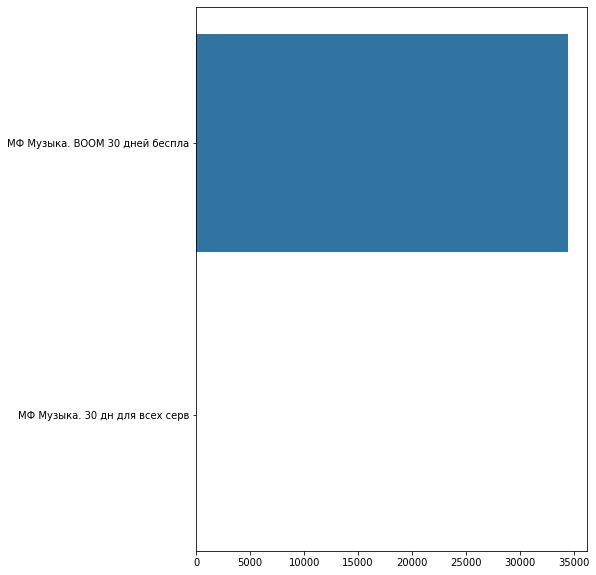

In [77]:
offer_density_top2(of_density_3)

In [87]:
def offer_density_top3(of_density):
    density_3 = dict()
    for user in X_test_real_positives_date.sk_subs_id:
        #print(user)
        temp = int(list(of_density[user])[0])
    
        if temp in density_3 :
                density_3[temp] += 1
        else :
                density_3[temp] = 1
    density_3 = {k: v for k, v in sorted(density_3.items(), key=lambda item: item[1], reverse = True)}
    print(density_3)
    offer_list = []
    offer_list = [key for key in density_3]
    print(offer_list)
    num_for_offer = [value for value in density_3.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    offer_list_head = [i[0][:30] for i in offer_list_head]
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    count = 0 
    for i in offer_list_head :
        count += 1
        print(f'{count}',i)

{1063012: 34514, 1007659: 5}
[1063012, 1007659]
1 МФ Музыка. 30 дн для всех серв
2 Выбирай любимые песни на гудки


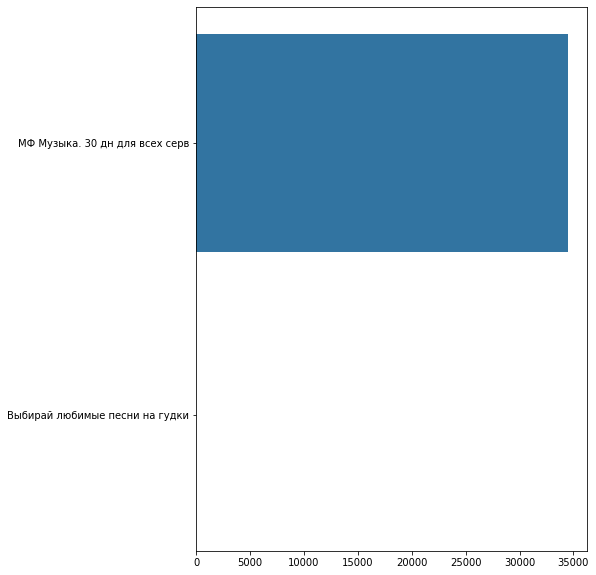

In [88]:
offer_density_top3(of_density_3)

In [238]:
    density_1 = dict()
    for user in data_test_pos.sk_subs_id:
        #print(user)
        temp = int(list(of_density_3[user])[0])
    
        if temp in density_1 :
                density_1[temp] += 1
        else :
                density_1[temp] = 1

In [239]:
density_1

{1007673: 15859,
 1062979: 854,
 1007659: 4388,
 1068899: 3595,
 1068897: 927,
 1063012: 5575,
 1062994: 18,
 1007675: 1653,
 1062993: 347,
 1068898: 168,
 1023788: 347,
 1023793: 108,
 1062996: 17,
 1062990: 64,
 1062998: 70,
 1063009: 75,
 1063014: 103,
 1062992: 50,
 1034318: 132,
 1063013: 140,
 1062997: 11,
 1062985: 1,
 1063010: 13,
 1062980: 2,
 1063005: 2}

распределение частоты офферов, которые предсказываются в топ К

In [111]:
def offer_distribution(of_density):
    density = dict()
    for user in X_test_real_positives_date.sk_subs_id:
        #print(user)
        temp = list(of_density[user])
       # print(temp[0])
        for k in range(len(temp)) :
           
            if temp[k] in density :
                density[temp[k]] += 1
            else :
                density[temp[k]] = 1
    density = {k: v for k, v in sorted(density.items(), key=lambda item: item[1], reverse = True)}
    density[1068899.0] = density[1068899.0]/2
    density[1007659.0] = density[1007659.0]/3
    density[1023788.0] = density[1023788.0] * 0.75 
    density[1062998.0] = density[1062998.0] * 0.8
    density[1007675.0] = density[1007675.0] * 0.85
    
    print(density)
    offer_list = []
    offer_list = [key for key in density]
    print(offer_list)
    num_for_offer = [value for value in density.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    #print(offer_list_head)
    offer_list_head = [i[0][:30] for i in offer_list_head]
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    count = 0 
    for i in offer_list_head :
        count +=1
        print(f'{count}',i)

{1068899.0: 17259.5, 1063012.0: 34519, 1063013.0: 34519, 1007659.0: 11506.333333333334, 1023788.0: 25889.25, 1062998.0: 27615.2, 1007675.0: 29341.149999999998, 1063005.0: 34519, 1063014.0: 25449, 1063015.0: 20048, 1062990.0: 17203, 1007676.0: 6338}
[1068899.0, 1063012.0, 1063013.0, 1007659.0, 1023788.0, 1062998.0, 1007675.0, 1063005.0, 1063014.0, 1063015.0, 1062990.0, 1007676.0]
1 МегаДиск. 100 ГБ бесплатно
2 МФ Музыка. 30 дн для всех серв
3 МФ Музыка. BOOM 30 дней беспла
4 Выбирай любимые песни на гудки
5 Промокод на бесплатный пробный
6 МегаФон ТВ. Кино по подп для р
7 Пакет "Максимальный" на 14 дне
8 Платежи и переводы. ЖКХ без ко
9 МФ Музыка. Звук 30 дней беспла
10 МФ Музыка. Звук для Развлекайс
11 МегаФон Пресса. Бесплатный Gla
12 Выбирай любимые песни на гудки


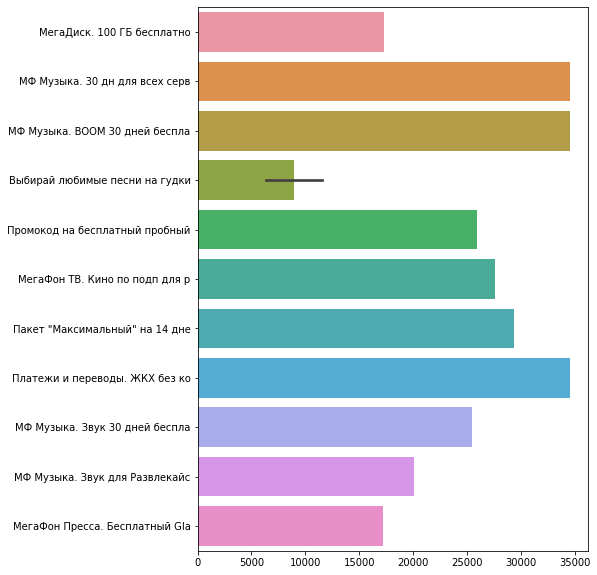

In [112]:
offer_distribution(of_density_10)

Скорим тестовую выборку,на которой будем учить следующую модель

In [181]:
score_df = lfm_model.predict(data_test_users =  X_test_balanced_prep_positives[user_cols + [user_id_col]],
                            data_test_items = X_test_balanced_prep_date[item_cols + [item_id_col]].drop_duplicates(['id_offer']),
                            n_jobs = 40,
                            mode = 0)

In [188]:
score_df.groupby('user_id').count()

,item_id,score,rank
user_id,,,
sk_subs_id:100008921.0,39,39,39
sk_subs_id:100015616.0,39,39,39
sk_subs_id:100028236.0,39,39,39
sk_subs_id:100038026.0,39,39,39
sk_subs_id:100100422.0,39,39,39
...,...,...,...
sk_subs_id:99934564.0,39,39,39
sk_subs_id:99950918.0,39,39,39
sk_subs_id:99983464.0,39,39,39


In [33]:
X_test_balanced_prep_date[item_cols + [item_id_col]].drop_duplicates(['id_offer']).shape

(39, 214)

In [34]:
X_test_balanced_prep_positives['sk_subs_id'].unique()

array(['sk_subs_id:10614303.0', 'sk_subs_id:22287024.0',
       'sk_subs_id:29477659.0', ..., 'sk_subs_id:591883589.0',
       'sk_subs_id:604252114.0', 'sk_subs_id:608625977.0'], dtype=object)

In [35]:
score_df.shape

(1002456, 3)

Присвоим ранги по каждому юзеру

In [183]:
score_df['rank'] = score_df.sort_values(['score'], ascending=[False]) \
             .groupby(['user_id']) \
             .cumcount() + 1

In [90]:
score_df.sort_values(['user_id', 'rank'])

KeyError: 'rank'

In [40]:
def train_xgb_prepare(score_df):
    user_id = []
    for i in range(len(score_df['user_id'].to_numpy())):
        user_id.append(float(score_df['user_id'].to_numpy()[i][11:]))
        
    id_offer = []
    for j in range(len(score_df['item_id'].to_numpy())):
        id_offer.append(float(score_df['item_id'].to_numpy()[j][9:]))
    return user_id, id_offer

In [91]:
score_df.head(5)

,user_id,item_id,score
0,6936218.0,1063011.0,-24.140236
1,6936218.0,1063005.0,-22.896231
2,6936218.0,1063010.0,-24.026100
3,6936218.0,1007659.0,-22.033670
4,6936218.0,1063009.0,-24.026220


In [192]:
user_id, id_offer = train_xgb_prepare(score_df)

score_df['user_id'] = user_id
score_df['item_id'] = id_offer

In [47]:
score_df.head()

,user_id,item_id,score,rank
0,10614303.0,1063012.0,-21.561924,1
1,10614303.0,1063010.0,-24.617487,20
2,10614303.0,1063011.0,-24.774647,23
3,10614303.0,1063009.0,-24.591797,18
4,10614303.0,1062979.0,-24.174286,11


In [48]:
score_df['user_id']

0           10614303.0
1           10614303.0
2           10614303.0
3           10614303.0
4           10614303.0
              ...     
1002451    608625977.0
1002452    608625977.0
1002453    608625977.0
1002454    608625977.0
1002455    608625977.0
Name: user_id, Length: 1002456, dtype: float64

In [43]:
with open('LightFM_base_pipe_2.pkl', 'wb') as file:
    pickle.dump(lfm_model, file)

In [17]:
with open('LightFM_base_pipe_2.pkl', 'rb') as f:
     lfm_model = pickle.load(f)

In [46]:
X_test_balanced[X_test_balanced['target'] == 0].drop_duplicates(['user_id', 'item_id']).head()

KeyError: Index(['item_id', 'user_id'], dtype='object')

## Работа с xgboost

Проведем merge  признаков с таблицей скоров полученных из lightfm

Сначала получим положительные сэмплы

In [49]:
X_test_balanced = X_test_balanced.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})
X_test_balanced_pos_date = X_test_balanced_pos_date.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})

In [50]:
X_test_balanced_pos_date.shape

(25704, 581)

In [51]:
X_test_balanced[X_test_balanced['target'] == 0].head()

,mapping_it_serv_hits_flg,mapping_user_education_flg,mapping_onb_psyhology_flg,mapping_interest_health_flg,mapping_books_usg_flg,mapping_onb_fashion_flg,mapping_onb_int_shop_flg,mapping_mftv_users_flg,mapping_interest_baby_toys_flg,mapping_travel_extra_flg,...,last_4g_date,sms_s1,health_travel_flg,roaming_flg,user_audiobook_flg,region,user_id,item_id,start_date,target
600875,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,130.0,NaN,0.0,1.0,0.0,NaN,4715645.0,1063012.0,1615755600,0.0
600876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.0,150.0,1.0,0.0,0.0,78.0,5312546.0,1063010.0,1615755600,0.0
600877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.0,128.0,1.0,0.0,0.0,77.0,6917497.0,1063011.0,1615755600,0.0
600878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.0,72.0,0.0,0.0,0.0,14.0,8563988.0,1063009.0,1615755600,0.0
600879,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,-6.0,52.0,1.0,0.0,0.0,78.0,10270030.0,1063012.0,1615755600,0.0


In [52]:
pos = X_test_balanced[X_test_balanced['target'] == 1].merge(score_df,
                        on=['user_id', 'item_id'],
                        how='inner')

In [53]:
pos.shape

(27586, 584)

# Получим негативные сэмплы

Antijoin

In [54]:
# Perform a left join
left_joined = score_df.merge(
  X_test_balanced_pos_date, how='left', 
  on=['user_id', 'item_id'], indicator=True)
left_joined.sample(5)

,user_id,item_id,score,rank,mapping_it_serv_hits_flg,mapping_user_education_flg,mapping_onb_psyhology_flg,mapping_interest_health_flg,mapping_books_usg_flg,mapping_onb_fashion_flg,...,onb_edu_tech_flg,mega_sms_gains,last_4g_date,sms_s1,health_travel_flg,roaming_flg,user_audiobook_flg,region,start_date,_merge
800922,614408229.0,1007676.0,-24.806999,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
466453,571719631.0,1062992.0,-22.827293,22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
483914,589808152.0,1062980.0,-23.222090,13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
795116,130749082.0,1023788.0,-22.713478,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
772821,561413393.0,1062985.0,-24.363079,38,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [55]:
neg = left_joined.loc[left_joined['_merge'] == 'left_only',[ 'user_id', 'item_id','rank']]

In [56]:
neg.head()

,user_id,item_id,rank
0,10614303.0,1063012.0,1
1,10614303.0,1063010.0,20
2,10614303.0,1063011.0,23
3,10614303.0,1063009.0,18
5,10614303.0,1063005.0,6


In [57]:
#Джоин признаков офферов
neg = neg.merge(
  X_test_balanced[item_cols + ['item_id']].drop_duplicates(['item_id']), how='left', 
      on=['item_id'], indicator=True)

#Джоин признаков юзеров 
neg = neg.merge(
  X_test_balanced[user_cols + ['user_id']], how='inner', 
  on=['user_id'])

In [58]:
neg['target'] = 0

In [59]:
neg.shape

(1079747, 583)

In [60]:
neg_train = neg.sample(frac=0.07)

In [108]:
train_xgboost = pd.concat([neg_train,pos])

In [141]:
train_xgboost

,item_id,rank,mapping_it_serv_hits_flg,mapping_user_education_flg,mapping_onb_psyhology_flg,mapping_interest_health_flg,mapping_books_usg_flg,mapping_onb_fashion_flg,mapping_onb_int_shop_flg,mapping_mftv_users_flg,...,mega_sms_gains,last_4g_date,sms_s1,health_travel_flg,roaming_flg,user_audiobook_flg,region,target,start_date,score
670113,1062990.0,17,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,-0.041667,-6.0,31.0,1.0,0.0,0.0,89.0,0.0,NaN,NaN
706277,1063012.0,1,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,...,0.184211,-6.0,20.0,1.0,0.0,0.0,72.0,0.0,NaN,NaN
991987,1062996.0,14,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.003802,NaN,71.0,1.0,0.0,0.0,75.0,0.0,NaN,NaN
849101,1062983.0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.340426,-6.0,61.0,1.0,1.0,0.0,27.0,0.0,NaN,NaN
130487,1063004.0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.176471,-6.0,48.0,1.0,0.0,0.0,58.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27581,1007659.0,4,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.857143,12.0,108.0,1.0,0.0,0.0,NaN,1.0,1.614546e+09,-21.321505
27582,1063005.0,6,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,NaN,-6.0,72.0,1.0,0.0,0.0,74.0,1.0,1.614546e+09,-23.176085
27583,1068899.0,5,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,...,0.066667,-6.0,29.0,0.0,0.0,0.0,74.0,1.0,1.614546e+09,-22.737013
27584,1007659.0,4,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,NaN,-6.0,55.0,0.0,0.0,0.0,67.0,1.0,1.614546e+09,-23.014498


In [ ]:
train_xgboost.to_csv('/data/isbagaut/train_xgb_19.01.csv')

In [115]:
train_xgboost = pd.read_csv('/data/isbagaut/train_xgb_06.01.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (217) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Построение модели xgboost 

Формируем тест и трейн,деля по юзерам 

In [116]:
train_xgboost = train_xgboost.iloc[:,1:]

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [118]:
train, test = train_test_split(train_xgboost,
                                                  random_state=1,
                                                  test_size=0.2)

In [119]:
# выделяем 10% под механизм early stopping
train, eval_ = train_test_split(train,
                                                  random_state=1,
                                                  test_size=0.1)

In [120]:
train['target'].value_counts(normalize=True)

0.0    0.732835
1.0    0.267165
Name: target, dtype: float64

In [121]:
test['target'].value_counts(normalize=True)

0.0    0.733789
1.0    0.266211
Name: target, dtype: float64

In [122]:
X_train  = train.loc[:, ~train.columns.isin(['target','_merge','start_date','score'])]
y_train = train.loc[:, train.columns.isin(['target'])]

In [123]:
X_eval = eval_.loc[:, ~eval_.columns.isin(['target','_merge','start_date','score'])]
y_eval = eval_.loc[:, eval_.columns.isin(['target'])]

In [124]:
X_test = test.loc[:,~test.columns.isin(['target','_merge','start_date','score'])]
y_test = test.loc[:, test.columns.isin(['target'])]

In [125]:
categorical_features = ['dvtp_dvtp_id', 'clst_clst_id', 'jrtp_jrtp_id', 'bseg_bseg_id', 'sbst_sbst_id', 
                        'filial_id', 'region', 'ctyp_ctyp_id', 'brnc_brnc_id', 'master_segment_id', 'subs_serv_status_id', 
                        'clcl_clcl_id', 'ccat_ccat_id', 'id_offer', 'id_product', 'mapping_smart_device_flg', 
                        'mapping_iphone_flg', 'mapping_dou_flg', 'mapping_mou_flg', 'mapping_streaming_audio_flg',
                        'mapping_streaming_video_flg', 'mapping_dou_100mb_flg', 'mapping_dou_1gb_flg', 
                        'mapping_mou_in_more_out_flg', 'mapping_mou_out_more_in_flg', 'mapping_mou_out_more_2in_flg',
                        'mapping_interest_movie_serials_flg', 'mapping_yandexmusic_streaming_flg', 'mapping_vk_ok_hits_flg',
                        'mapping_hypermarket_hits_flg', 'mapping_detskie_tov_hits_flg', 'mapping_eda_hits_flg', 
                        'mapping_pets_hits_flg', 'mapping_kitai_hits_flg', 'mapping_books_hits_flg', 
                        'mapping_beauty_hits_flg', 'mapping_cash_hits_flg', 'mapping_clothes_hits_flg', 
                        'mapping_education_hits_flg', 'mapping_enter_hits_flg', 'mapping_sport_hits_flg', 
                        'mapping_insure_hits_flg', 'mapping_home_hits_flg', 'mapping_accessory_hits_flg', 
                        'mapping_tourism_hits_flg', 'mapping_electronics_hits_flg', 'mapping_rod_control_hits_flg',
                        'mapping_tv_channels_hits_flg', 'mapping_music_hits_flg', 
                        'mapping_other_tv_channels_hits_flg', 'mapping_tariff_listen_flg', 'mapping_tariff_listen_old_flg',
                        'mapping_video_flg', 'mapping_audio_flg', 'mapping_cash_flg', 'mapping_mou_300_flg', 
                        'mapping_os_android_flg', 'mapping_os_ios_flg', 'mapping_it_serv_hits_flg', 'mapping_avto_hits_flg',
                        'mapping_kino_hits_flg', 'mapping_antivirus_flg', 'mapping_rod_control_flg', 'mapping_press_flg', 
                        'mapping_virt_cards_flg', 'mapping_nfc_flg', 'mapping_banks_flg', 'mapping_shops_flg', 
                        'mapping_health_general_flg', 'mapping_health_travel_flg', 'mapping_travel_avia_flg', 
                        'mapping_travel_hotels_flg', 'mapping_travel_rzd_flg', 'mapping_travel_tour_flg', 
                        'mapping_travel_extra_flg', 'mapping_travel_general_flg', 'mapping_books_flg', 
                        'mapping_press_web_flg', 'mapping_health_zog_flg', 'mapping_health_mom_flg', 
                        'mapping_interest_kids_flg', 'mapping_interest_health_flg', 'mapping_interest_health_zog_flg',
                        'mapping_interest_health_travel_flg', 'mapping_interest_mom_flg', 'mapping_interest_travel_flg',
                        'mapping_up_cashback_flg', 'mapping_music_flg', 'mapping_zam_gud_flg', 'mapping_person_gud_flg', 
                        'mapping_auto_answ_flg', 'mapping_mftv_general_flg', 'mapping_mftv_tvshow_flg', 
                        'mapping_mftv_kids_flg', 'mapping_data_torrents_flg', 'mapping_data_play_market_flg', 
                        'mapping_data_appstore_flg', 'mapping_roaming_flg', 'mapping_mftv_users_flg', 
                        'mapping_sms_healthy_flg', 'mapping_sms_shop_flg', 'mapping_sms_tv_flg', 'mapping_sms_banks_flg',
                        'mapping_sms_kids_flg', 'mapping_b2c_flg', 'mapping_books_usg_flg', 'mapping_sms_oil_flg', 
                        'mapping_sms_ticket_flg', 'mapping_sms_supermrkt_flg', 'mapping_user_audiobook_flg', 
                        'mapping_user_tinder_flg', 'mapping_user_education_flg', 'mapping_user_stop_ad_flg', 
                        'mapping_user_knowcalling_flg', 'mapping_user_bank_entertain', 'mapping_url_tinder_flg', 
                        'mapping_url_edu_flg', 'mapping_url_audiobooks_flg', 'mapping_url_stop_ad_flg', 
                        'mapping_interest_mortgage_flg', 'mapping_interest_auto_flg', 'mapping_interest_entertain_flg', 
                        'mapping_interest_cooking_flg', 'mapping_interest_cafe_flg', 'mapping_user_bank_oil', 
                        'mapping_user_bank_cafe', 'mapping_user_bank_market', 'mapping_user_bank_taxi', 
                        'mapping_user_detsk_intern1_flg', 'mapping_user_detsk_intern2_flg', 'mapping_sms_carshar_taxi_flg',
                        'mapping_url_videogames_flg', 'mapping_url_press_user_psychology_flg', 'mapping_interest_edu_flg', 
                        'mapping_interest_finance_flg', 'mapping_interest_jobs_flg', 'mapping_mob_com_flg', 'mapping_user_games_flg', 
                        'mapping_user_autopay_flg', 'mapping_call_mts_flg', 'mapping_cvm_audiobooks_flg', 'mapping_cvm_date_flg',
                        'mapping_cvm_books_flg', 'mapping_interest_baby_toys_flg', 'mapping_interest_around_the_world_flg', 
                        'mapping_interest_tech_flg', 'mapping_interest_clothes_flg', 'mapping_interest_beauty_flg', 
                        'mapping_cvm_zam_gud_flg', 'mapping_mftv_moretv_flg', 'mapping_mftv_film_flg', 'mapping_phone_flg', 
                        'mapping_tablet_flg', 'mapping_tariff_vkl_flg', 'mapping_trf_warm_reception_flg', 'mapping_east_calls_flg', 
                        'mapping_is_man_flg', 'mapping_is_woman_flg', 'mapping_user_it_flg', 'mapping_user_marketing_flg', 
                        'mapping_user_management_flg', 'mapping_user_finance_flg', 'mapping_user_sub_sport_flg', 
                        'mapping_user_prediction_flg', 'mapping_user_national_recipe_flg', 'mapping_user_news_sng_flg', 
                        'mapping_user_vas_flg', 'mapping_card_mastercard_flg', 'mapping_card_visa_flg', 'mapping_payment_out_3_flg',
                        'mapping_payment_out_6_flg', 'mapping_is_top_user_flg', 'mapping_pets_sms_flg', 'mapping_user_health_flg', 
                        'mapping_cvm_health_flg', 'mapping_webmail_top8_flg', 'mapping_cloud_services_top8_flg', 
                        'mapping_file_dnld_share_top8_flg', 'mapping_data_traffic_ptl70_flg', 'mapping_mf_tv_mod_flg',
                        'mapping_specii_mod_flg', 'mapping_audiobooks_mod_flg', 'mapping_zg_mod_flg', 'mapping_mf_music_mod_flg',
                        'mapping_marketplace_mod_flg', 'mapping_pers_gudok_mod_flg', 'mapping_paym_trans_mod_flg', 
                        'mapping_autopay_mod_flg', 'mapping_paym_transf_forb_mod_flg', 'mapping_pers_gudok_forb_mod_flg', 
                        'mapping_marketplace_forb_mod_flg', 'mapping_onb_antivir_flg', 'mapping_onb_zoo_flg', 
                        'mapping_onb_med_online_flg', 'mapping_onb_fitness_flg', 'mapping_onb_edu_online_flg', 
                        'mapping_onb_books_flg', 'mapping_onb_audiobooks_flg', 'mapping_onb_edu_tech_flg', 'mapping_onb_psyhology_flg',
                        'mapping_onb_int_shop_flg', 'mapping_onb_food_delivery_flg', 'mapping_onb_dress_flg', 'mapping_onb_tech_flg', 
                        'mapping_onb_flower_flg', 'mapping_onb_home_flg', 'mapping_onb_music_flg', 'mapping_onb_movie_flg', 
                        'mapping_onb_video_flg', 'mapping_onb_games_flg', 'mapping_onb_fashion_flg', 'mapping_onb_bcard_flg', 
                        'mapping_onb_cashback_flg', 'mapping_onb_payments_flg', 'mapping_onb_insurance_flg', 'mapping_is_male_flg', 
                        'mapping_specii_v2_flg', 'mapping_megadisk_flg', 'mapping_mf_tv_v2_flg', 'mapping_mf_music_v2_flg', 
                        'mapping_paym_transf_v2_flg', 'mapping_zg_v2_flg']

In [126]:
cat_features = [i for i in categorical_features if i in train.columns]

In [127]:
len(cat_features)

211

In [128]:
import category_encoders as ce 

/usr/local/lib64/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [129]:
ce.__version__

'2.2.2'

In [130]:
cbe_encoder = ce.cat_boost.CatBoostEncoder(cols = cat_features)
cbe_encoder.fit_transform(X_train, y_train)

/home/isbagaut/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,user_id,item_id,rank,mapping_it_serv_hits_flg,mapping_user_education_flg,mapping_onb_psyhology_flg,mapping_interest_health_flg,mapping_books_usg_flg,mapping_onb_fashion_flg,mapping_onb_int_shop_flg,...,last_mf_rm_date,mf_music_cr_m3,onb_edu_tech_flg,mega_sms_gains,last_4g_date,sms_s1,health_travel_flg,roaming_flg,user_audiobook_flg,region
90235,600903796.0,1063012.0,1,0.267165,0.267165,0.267165,0.267165,0.267165,0.267165,0.267165,...,NaN,NaN,0.0,NaN,-4.0,19.0,0.0,0.0,0.0,0.267165
85974,610353116.0,1063013.0,2,0.633582,0.633582,0.267165,0.633582,0.633582,0.267165,0.267165,...,NaN,NaN,0.0,NaN,-4.0,12.0,0.0,0.0,0.0,0.267165
53731,494598418.0,1068899.0,5,0.755722,0.755722,0.633582,0.755722,0.755722,0.633582,0.633582,...,NaN,NaN,0.0,-0.586207,-3.0,4.0,0.0,0.0,0.0,0.267165
11001,541406369.0,1007675.0,21,0.566791,0.566791,0.422388,0.566791,0.566791,0.422388,0.422388,...,25.0,NaN,0.0,1.395062,-4.0,446.0,1.0,0.0,0.0,0.267165
12721,48062159.0,1063001.0,35,0.453433,0.453433,0.633582,0.453433,0.453433,0.633582,0.633582,...,NaN,1.0,0.0,-0.206897,-6.0,73.0,1.0,0.0,0.0,0.267165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102984,592174364.0,1063012.0,1,0.267156,0.267156,0.302198,0.267156,0.277447,0.377409,0.395203,...,NaN,NaN,0.0,NaN,-6.0,40.0,0.0,0.0,0.0,0.269311
15867,7844224.0,1063019.0,28,0.267166,0.267166,0.254562,0.267166,0.016479,0.238648,0.203314,...,77.0,NaN,0.0,-0.700000,NaN,11.0,0.0,0.0,0.0,0.268740
88753,608496871.0,1023788.0,3,0.267162,0.267162,0.254557,0.267162,0.277457,0.377450,0.395228,...,NaN,0.5,0.0,0.866667,-6.0,59.0,1.0,0.0,0.0,0.270917
74646,596517718.0,1062990.0,17,0.267172,0.267172,0.302234,0.267172,0.277467,0.377491,0.203310,...,NaN,NaN,0.0,NaN,-6.0,45.0,0.0,0.0,0.0,0.271589


In [131]:
#X_train = cbe_encoder.transform(X_train)
X_test = cbe_encoder.transform(X_test)

In [132]:
X_test

,user_id,item_id,rank,mapping_it_serv_hits_flg,mapping_user_education_flg,mapping_onb_psyhology_flg,mapping_interest_health_flg,mapping_books_usg_flg,mapping_onb_fashion_flg,mapping_onb_int_shop_flg,...,last_mf_rm_date,mf_music_cr_m3,onb_edu_tech_flg,mega_sms_gains,last_4g_date,sms_s1,health_travel_flg,roaming_flg,user_audiobook_flg,region
14415,546834674.0,1007673.0,26,0.267165,0.267165,0.254566,0.267165,0.277459,0.238640,0.203302,...,NaN,NaN,0.0,-0.369565,-6.0,50.0,0.0,0.0,0.0,0.264084
48904,17923670.0,1034318.0,23,0.267165,0.267165,0.254566,0.267165,0.277459,0.238640,0.203302,...,-6.0,NaN,0.0,NaN,784.0,20.0,0.0,0.0,0.0,0.273487
37627,508105914.0,1068899.0,5,0.267165,0.267165,0.302218,0.267165,0.277459,0.377466,0.395252,...,-4.0,NaN,0.0,NaN,NaN,35.0,0.0,0.0,0.0,0.273487
23545,606102269.0,1034319.0,34,0.267165,0.267165,0.254566,0.267165,0.277459,0.238640,0.203302,...,NaN,0.0,0.0,6.800000,-6.0,58.0,0.0,0.0,0.0,0.255868
2902,543998477.0,1063009.0,18,0.267165,0.267165,0.254566,0.267165,0.277459,0.238640,0.203302,...,232.0,1.0,0.0,-0.767123,31.0,63.0,1.0,0.0,0.0,0.273292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69304,577852469.0,1062983.0,19,0.267165,0.267165,0.254566,0.267165,0.277459,0.238640,0.203302,...,NaN,0.0,0.0,-0.264151,-6.0,54.0,0.0,0.0,0.0,0.248966
35847,560450678.0,1023793.0,26,0.267165,0.267165,0.254566,0.267165,0.277459,0.238640,0.203302,...,132.0,NaN,0.0,-0.604651,538.0,27.0,0.0,0.0,0.0,0.271591
92302,38320175.0,1007659.0,4,0.267165,0.267165,0.302218,0.267165,0.277459,0.238640,0.395252,...,271.0,NaN,0.0,0.861111,-5.0,59.0,0.0,0.0,0.0,0.274869
452,608629880.0,1062994.0,25,0.267165,0.267165,0.254566,0.267165,0.277459,0.238640,0.203302,...,NaN,0.0,0.0,-0.305556,24.0,7.0,0.0,0.0,0.0,0.273487


In [133]:
X_eval = cbe_encoder.transform(X_eval)

In [134]:
eval_set = [(X_eval, y_eval)]

In [135]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()

In [136]:
xgb_cl.fit(X_train, y_train,eval_metric="error", eval_set=eval_set, verbose=True)

/home/isbagaut/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-error:0.15059
[1]	validation_0-error:0.14417
[2]	validation_0-error:0.14720
[3]	validation_0-error:0.11061
[4]	validation_0-error:0.10795
[5]	validation_0-error:0.10480
[6]	validation_0-error:0.09729
[7]	validation_0-error:0.09244
[8]	validation_0-error:0.08335
[9]	validation_0-error:0.08905
[10]	validation_0-error:0.08057
[11]	validation_0-error:0.08057
[12]	validation_0-error:0.08093
[13]	validation_0-error:0.08032
[14]	validation_0-error:0.08069
[15]	validation_0-error:0.08057
[16]	validation_0-error:0.07863
[17]	validation_0-error:0.07705
[18]	validation_0-error:0.07827
[19]	validation_0-error:0.07814
[20]	validation_0-error:0.07754
[21]	validation_0-error:0.07814
[22]	validation_0-error:0.07742
[23]	validation_0-error:0.07633
[24]	validation_0-error:0.07620
[25]	validation_0-error:0.07560
[26]	validation_0-error:0.07548
[27]	validation_0-error:0.07584
[28]	validation_0-error:0.07524
[29]	validation_0-error:0.07524
[30]	validation_0-error:0.07475
[31]	validation_0-

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [137]:
with open('xgb_base_pipe_.pkl', 'wb') as file:
    pickle.dump(xgb_cl, file)

In [138]:
preds = xgb_cl.predict_proba(X_test)

In [139]:
preds_u_i = X_test[['user_id', 'item_id']]
preds_u_i['pred'] = preds[:,1:].copy()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [140]:
preds_u_i

,user_id,item_id,pred
14415,546834674.0,1007673.0,0.009086
48904,17923670.0,1034318.0,0.008485
37627,508105914.0,1068899.0,0.220162
23545,606102269.0,1034319.0,0.000499
2902,543998477.0,1063009.0,0.063537
...,...,...,...
69304,577852469.0,1062983.0,0.004218
35847,560450678.0,1023793.0,0.011989
92302,38320175.0,1007659.0,0.997541
452,608629880.0,1062994.0,0.027421


In [141]:
preds_u_i.sort_values(['pred'],ascending=False).groupby('user_id').head(5)

,user_id,item_id,pred
90050,559210923.0,1034318.0,0.999954
80440,387272990.0,1034318.0,0.999940
89518,576642901.0,1034318.0,0.999898
82593,86150191.0,1034318.0,0.999886
82594,86150191.0,1034318.0,0.999886
...,...,...,...
5982,603109416.0,1062981.0,0.000003
38317,604240187.0,1062981.0,0.000003
23625,610374940.0,1063014.0,0.000003
27631,145147257.0,1062981.0,0.000003


In [142]:
preds_u_i[preds_u_i['user_id'] == 559210923.0]

,user_id,item_id,pred
90050,559210923.0,1034318.0,0.999954
8632,559210923.0,1062996.0,0.002131
33784,559210923.0,1062985.0,0.001176
18639,559210923.0,1063019.0,0.008183
81494,559210923.0,1063013.0,0.070072


In [143]:
print(y_test)

       target
14415     0.0
48904     0.0
37627     0.0
23545     0.0
2902      0.0
...       ...
69304     0.0
35847     0.0
92302     1.0
452       0.0
6486      0.0

[20634 rows x 1 columns]


In [144]:
from sklearn.metrics import accuracy_score

In [145]:
preds[0]

array([0.9909144 , 0.00908558], dtype=float32)

In [146]:
accuracy_score(y_test, preds[])

SyntaxError: invalid syntax (<ipython-input-146-46120ec71ce0>, line 1)

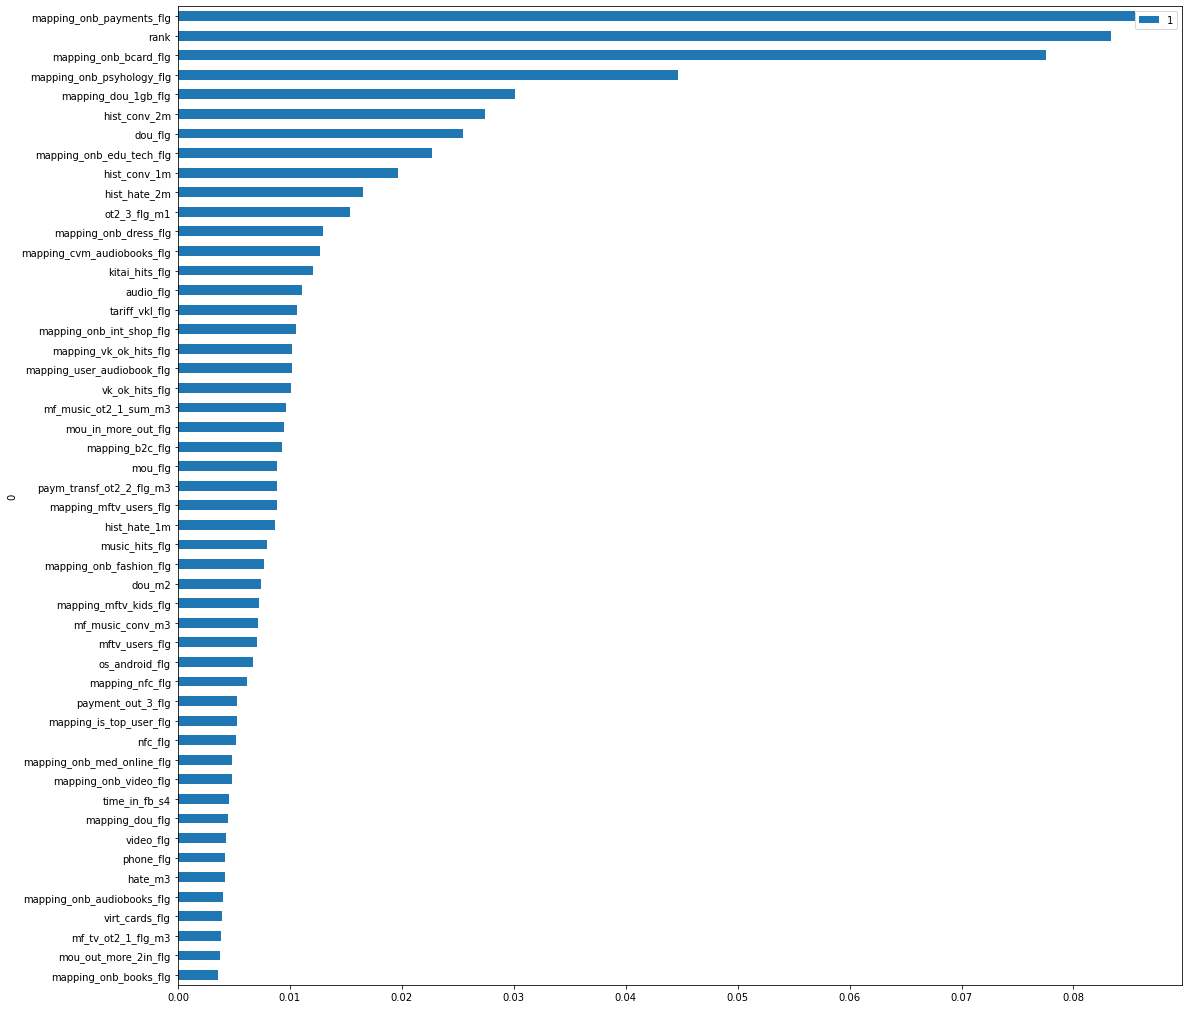

In [147]:
mapper = {i: v for i, v in zip(X_train.columns, xgb_cl.feature_importances_)}
n_feature = 50

feats_1 = pd.DataFrame(list(mapper.items())).sort_values([1],ascending=False)
feats_1.set_index([0])[:n_feature].sort_values([1],ascending=True).plot(figsize=(18, 18), kind='barh');

In [148]:
import shap

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [149]:
shap.__version__

'0.39.0'

In [150]:
shap.initjs()

In [151]:
explainer = shap.TreeExplainer(xgb_cl)

In [152]:
shap_values = explainer.shap_values(X_test)

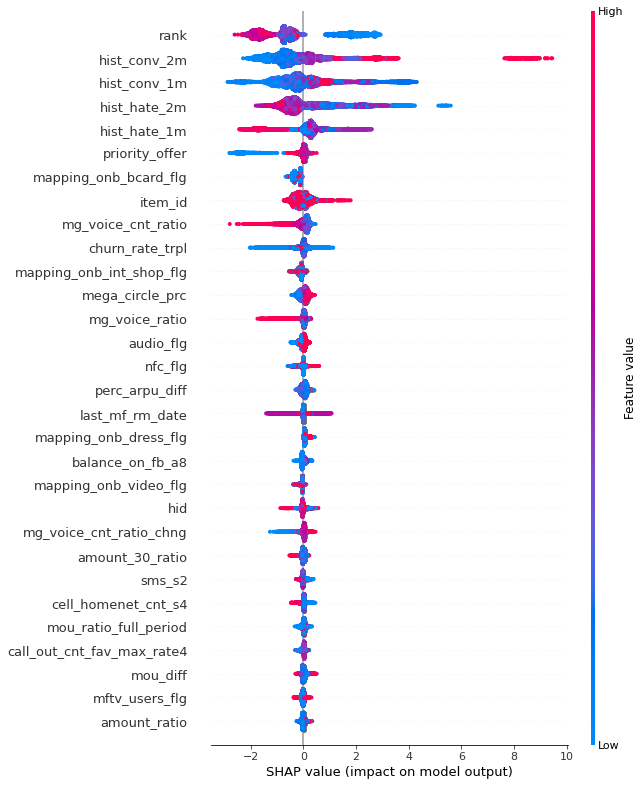

In [154]:
shap.summary_plot(shap_values, max_display = 30, features = X_test , feature_names = X_test.columns)

In [172]:
X_test_real_positives_date.id_offer

57         1063010.0
86         1034318.0
113        1007659.0
118        1034318.0
212        1068899.0
             ...    
1043135    1062990.0
1043179    1007659.0
1043202    1062998.0
1043203    1007659.0
1043210    1063012.0
Name: id_offer, Length: 34519, dtype: float64

In [214]:
X_train_positives_date.id_offer.plot.density(color='green')

NameError: name 'X_train_positives_date' is not defined

In [218]:
df_train.id_offer.unique()

array([1023788., 1007689., 1007696., 1007695., 1063005., 1007673.,
       1062980., 1063013., 1007691., 1062983., 1007659., 1062991.,
       1063010., 1007676., 1007697., 1063012., 1062979., 1062992.,
       1068899., 1007700., 1063009., 1063018., 1062998., 1062997.,
       1007704., 1062996., 1007703., 1007702., 1063000., 1023793.,
       1063008., 1062995., 1063014., 1063019., 1062985., 1062989.,
       1063004., 1007698., 1063001., 1023792., 1007709., 1007675.,
       1062981., 1007692., 1062990., 1007705., 1062994., 1063011.,
       1034319., 1068897., 1062993., 1007699., 1063007., 1068898.,
       1007693., 1007694., 1062988., 1063002., 1063003., 1062982.,
       1063017., 1062984., 1062986., 1062987., 1034318., 1063006.,
       1063015.])

In [213]:
X_test_real_positives_date.id_offer.unique()

array([1063010., 1034318., 1007659., 1068899., 1063011., 1063005.,
       1063012., 1063009., 1062979., 1062997., 1063013., 1023788.,
       1007676., 1063018., 1007675., 1062980., 1063014., 1062990.,
       1063019., 1023793., 1007673., 1062996., 1063008., 1062991.,
       1062998., 1068898., 1062994., 1034319., 1062992., 1062995.,
       1062985., 1063004.])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='id_offer'>

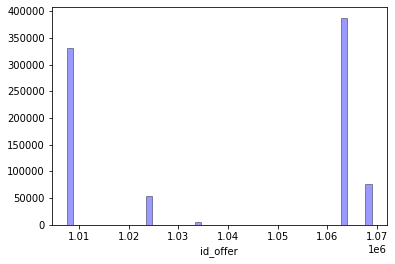

In [219]:
sns.distplot(df_train.id_offer, hist=True, kde=False, 
              color = 'blue',
             hist_kws={'edgecolor':'black'})

In [184]:
X_test_real_positives_date.shape

(34519, 581)

In [207]:
df_ = X_train[X_train['target'] == 1].copy()

KeyError: 'target'

In [205]:
df_['ind'] = 1

In [206]:
df_[['ind','item_id']].groupby('item_id').count()

,ind
item_id,
1007659.0,2955
1007673.0,1582
1007675.0,1503
1007676.0,1614
1023788.0,3048
1023792.0,1482
1023793.0,1442
1034318.0,4279
1034319.0,1415


## Закончили обучение модели

In [155]:
 score_df = lfm_model.predict(data_test_users =  X_test_real_prep_positives[user_cols + [user_id_col]],
                            data_test_items =   X_test_real_prep_date[item_cols + [item_id_col]].drop_duplicates(['id_offer']),
                            n_jobs = 40,
                            mode = 0)

In [156]:
X_test_real_prep_date = X_test_real_prep_date.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})
X_test_real_prep_positives = X_test_real_prep_positives.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})

In [157]:
features_ = X_train.columns

In [158]:
def accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                  user_id_column_p, user_id_column_r, 
                  item_id_column_p, item_id_column_r,
                  score_column, k = 5):
    '''
    Метрика, на основе которой можно проверить качество предсказания и ранжирования.
    Принимает на вход датафрейм с результатами предсказаний модели и датафрейм с 
    парами пользователь-сущность, когда был положительный отклик.
    Возвращает долю попаданий выбранного пользователем объекта в топ k скоров по модели
    Требует, чтобы пользователи в датафреймах не повторялись, при этом объекты в 
    таблице со скорами не должны повторяться в срезе по пользователю
    '''
    result = {}
    data_pred = users_items_scores_prediction.copy()
    data_real = users_items_real_interactions.copy()
    for (user, df_user) in  data_pred.groupby(user_id_column_p):        
        df_top_k = df_user.sort_values(score_column, ascending=False).iloc[:k]
        top_k_items = set(df_top_k[item_id_column_p].values)       
        real_item_id = data_real[item_id_column_r][data_real[user_id_column_r] == user].values[0]      
        if real_item_id in top_k_items:
            result[user] = 1
        else: 
            result[user] = 0
    #print(result)
    return np.sum(list(result.values())) / len(result)

In [159]:
%%time
acc_at_3_list = []
acc_at_5_list = []
acc_at_10_list = []
for (date, df_date), (date1, df_pos_date) in zip(X_test_real_all_date.groupby('start_date'),
                                               X_test_real_positives_date.groupby('start_date')):
    assert date1 == date
    print(pd.to_datetime(date, unit='s'))
    X_test_real_mapping = df_date[item_cols + [item_id_col]].drop_duplicates()
    print(X_test_real_mapping.shape)
    
    user_df = df_pos_date.copy()[user_cols + [user_id_col]]
    items_df = X_test_real_mapping.copy()    
    
    

    X_test_real_prep_date = pd.concat([lfm_model.transform(df_date.drop(['target', 'start_date'], axis = 1)),
                                   df_date[['start_date']]], axis = 1)
    X_test_real_prep_positives = pd.concat([lfm_model.transform(df_pos_date.drop('start_date', axis = 1)),
                                        df_pos_date[['start_date']]], axis = 1)
    
    
    score_df = lfm_model.predict(data_test_users =  X_test_real_prep_positives[user_cols + [user_id_col]],
                            data_test_items = X_test_real_prep_date[item_cols + [item_id_col]].drop_duplicates(['id_offer']),
                            n_jobs = 40,
                            mode = 0)
    
    user_id, id_offer = train_xgb_prepare(score_df)
    
    score_df['user_id'] = user_id
    score_df['item_id'] = id_offer
   
    score_df['rank'] = score_df.sort_values(['score'], ascending=[False]) \
             .groupby(['user_id']) \
             .cumcount() + 1

    score_df = score_df[score_df['rank'] <= 10]
    
    user_id_column = score_df['user_id']
    id_offer_column = score_df['item_id']
    
    user_df_join = user_df.copy()
    items_df_join = items_df.copy()
    
    
    user_df_join = user_df_join.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})
    items_df_join = items_df_join.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})
    
    
    
    #Джоин признаков офферов
    score_df = score_df.merge(
      items_df_join.drop_duplicates(['item_id']), how='left', 
      on=['item_id'], indicator=True)

    #Джоин признаков юзеров 
    score_df = score_df.merge(
        user_df_join, how='inner', 
        on=['user_id'])
    
    score_df = score_df.loc[:, score_df.columns.isin(features_)]
   
    
    score_df = cbe_encoder.transform(score_df)
    
    preds = xgb_cl.predict_proba(score_df)
    
    
    user_id_column = user_id_column.reset_index(drop= True)
    id_offer_column = id_offer_column.reset_index(drop = True)
    preds = pd.Series(preds[:,1:].flatten()).reset_index(drop = True)

    users_items_scores_prediction = pd.DataFrame({'user_id': user_id_column, 'id_offer': id_offer_column, 'score':preds})
    
    users_items_real_interactions = df_pos_date[['sk_subs_id', 'id_offer']] 
   # print(users_items_real_interactions)
    
    acc_at_3 = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 3)    
    acc_at_3_list.append(acc_at_3)                                           
                                                
    acc_at_5 = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 5)    
    acc_at_5_list.append(acc_at_5)    
                                                
    acc_at_10 = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 10)    
    acc_at_10_list.append(acc_at_10) 

print('ok')

2021-03-28 21:00:00
(38, 214)
2021-04-04 21:00:00
(39, 214)
2021-04-11 21:00:00
(39, 214)
2021-04-18 21:00:00
(32, 214)
ok
CPU times: user 48min 55s, sys: 2min 41s, total: 51min 36s
Wall time: 34min 59s


In [160]:
print(acc_at_3_list)
print(acc_at_5_list)
print(acc_at_10_list)

[0.42120343839541546, 0.21664313448641018, 0.22270742358078602, 0.20626249167221852]
[0.5871060171919771, 0.5233851041298976, 0.5126407722362675, 0.6728847435043305]
[0.6803724928366762, 0.6024532297917402, 0.6167547690186164, 0.8127914723517655]


## Проведем подбор гиперпараметров 

## Распределение офферов

In [161]:
def accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                  user_id_column_p, user_id_column_r, 
                  item_id_column_p, item_id_column_r,
                  score_column, k = 5):
    '''
    Метрика, на основе которой можно проверить качество предсказания и ранжирования.
    Принимает на вход датафрейм с результатами предсказаний модели и датафрейм с 
    парами пользователь-сущность, когда был положительный отклик.
    Возвращает долю попаданий выбранного пользователем объекта в топ k скоров по модели
    Требует, чтобы пользователи в датафреймах не повторялись, при этом объекты в 
    таблице со скорами не должны повторяться в срезе по пользователю
    '''
    result = {}
    of_density = {}
    data_pred = users_items_scores_prediction.copy()
    #print(data_pred)
    data_real = users_items_real_interactions.copy()
    for (user, df_user) in  data_pred.groupby(user_id_column_p):        
        df_top_k = df_user.sort_values(score_column, ascending=False).iloc[:k]
        top_k_items = set(df_top_k[item_id_column_p].values)       
        real_item_id = data_real[item_id_column_r][data_real[user_id_column_r] == user].values[0]      
        if real_item_id in top_k_items:
            result[user] = 1
        else:
            result[user] = 0
    #print(result)
        of_density[user] = top_k_items
        #of_density[str(user) + '_' + str(real_item_id)] = real_item_id
        
    return np.sum(list(result.values())) / len(result), of_density

In [166]:
%%time
acc_at_3_list = []
acc_at_5_list = []
acc_at_10_list = []
of_density_1 = dict()
of_density_3 = dict()
of_density_5 = dict()
of_density_10 = dict()
score_table = pd.DataFrame(columns = ['user_id','id_offer','score'])

for (date, df_date), (date1, df_pos_date) in zip(X_test_real_all_date.groupby('start_date'),
                                               X_test_real_positives_date.groupby('start_date')):
    assert date1 == date
    print(pd.to_datetime(date, unit='s'))
    X_test_real_mapping = df_date[item_cols + [item_id_col]].drop_duplicates()
    print(X_test_real_mapping.shape)
    
    user_df = df_pos_date.copy()[user_cols + [user_id_col]]
    items_df = X_test_real_mapping.copy()    
    
    

    X_test_real_prep_date = pd.concat([lfm_model.transform(df_date.drop(['target', 'start_date'], axis = 1)),
                                   df_date[['start_date']]], axis = 1)
    X_test_real_prep_positives = pd.concat([lfm_model.transform(df_pos_date.drop('start_date', axis = 1)),
                                        df_pos_date[['start_date']]], axis = 1)
    
    
    score_df = lfm_model.predict(data_test_users =  X_test_real_prep_positives[user_cols + [user_id_col]],
                            data_test_items = X_test_real_prep_date[item_cols + [item_id_col]].drop_duplicates(['id_offer']),
                            n_jobs = 40,
                            mode = 0)
    
    user_id, id_offer = train_xgb_prepare(score_df)
    
    score_df['user_id'] = user_id
    score_df['item_id'] = id_offer
   
    score_df['rank'] = score_df.sort_values(['score'], ascending=[False]) \
             .groupby(['user_id']) \
             .cumcount() + 1

    score_df = score_df[score_df['rank'] <= 10]
    
    user_id_column = score_df['user_id']
    id_offer_column = score_df['item_id']
    
    user_df_join = user_df.copy()
    items_df_join = items_df.copy()
    
    
    user_df_join = user_df_join.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})
    items_df_join = items_df_join.rename(columns={"sk_subs_id": "user_id", "id_offer": "item_id"})
    
    
    
    #Джоин признаков офферов
    score_df = score_df.merge(
      items_df_join.drop_duplicates(['item_id']), how='left', 
      on=['item_id'], indicator=True)

    #Джоин признаков юзеров 
    score_df = score_df.merge(
        user_df_join, how='inner', 
        on=['user_id'])
    
    score_df = score_df.loc[:, score_df.columns.isin(features_)]
   
    
    score_df = cbe_encoder.transform(score_df)
    
    preds = xgb_cl.predict_proba(score_df)
    
    
    user_id_column = user_id_column.reset_index(drop= True)
    id_offer_column = id_offer_column.reset_index(drop = True)
    preds = pd.Series(preds[:,1:].flatten()).reset_index(drop = True)

    users_items_scores_prediction = pd.DataFrame({'user_id': user_id_column, 'id_offer': id_offer_column, 'score':preds})
    
    users_items_real_interactions = df_pos_date[['sk_subs_id', 'id_offer']] 
   # print(users_items_real_interactions)
    
    
    
    _, of_density_1_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 1)   
    acc_at_3, of_density_3_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 3)    
    acc_at_3_list.append(acc_at_3)                                           
                                                
    acc_at_5, of_density_5_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 5)    
    acc_at_5_list.append(acc_at_5)    
                                                
    acc_at_10, of_density_10_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 10)    
    acc_at_10_list.append(acc_at_10) 
    #print((of_density_3_temp))
    of_density_1.update(of_density_1_temp)
    of_density_3.update(of_density_3_temp)
    of_density_5.update(of_density_5_temp)
    of_density_10.update(of_density_10_temp)
   #print(of_density_3)
   
print('ok')

2021-03-28 21:00:00
(38, 214)
2021-04-04 21:00:00
(39, 214)
2021-04-11 21:00:00
(39, 214)
2021-04-18 21:00:00
(32, 214)
ok
CPU times: user 50min 56s, sys: 2min 13s, total: 53min 10s
Wall time: 35min 30s


In [167]:
def offer_distribution(of_density):
    density = dict()
    for user in X_test_real_positives_date.sk_subs_id:
        #print(user)
        temp = list(of_density[user])
       # print(temp[0])
        for k in range(len(temp)) :
           
            if temp[k] in density :
                density[temp[k]] += 1
            else :
                density[temp[k]] = 1
                
    density = {k: v for k, v in sorted(density.items(), key=lambda item: item[1], reverse = True)}
    
    print(density)
    offer_list = []
    offer_list = [key for key in density]
    print(offer_list)
    num_for_offer = [value for value in density.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    #print(offer_list_head)
    offer_list_head = [i[0][:30] for i in offer_list_head]
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    count = 0 
    for i in offer_list_head :
        count +=1
        print(f'{count}',i)

{1068899.0: 34519, 1063012.0: 34519, 1063013.0: 34519, 1007659.0: 34519, 1023788.0: 34519, 1062998.0: 34519, 1007675.0: 34519, 1063005.0: 34519, 1063014.0: 25449, 1063015.0: 20048, 1062990.0: 17203, 1007676.0: 6338}
[1068899.0, 1063012.0, 1063013.0, 1007659.0, 1023788.0, 1062998.0, 1007675.0, 1063005.0, 1063014.0, 1063015.0, 1062990.0, 1007676.0]
1 МегаДиск. 100 ГБ бесплатно
2 МФ Музыка. 30 дн для всех серв
3 МФ Музыка. BOOM 30 дней беспла
4 Выбирай любимые песни на гудки
5 Промокод на бесплатный пробный
6 МегаФон ТВ. Кино по подп для р
7 Пакет "Максимальный" на 14 дне
8 Платежи и переводы. ЖКХ без ко
9 МФ Музыка. Звук 30 дней беспла
10 МФ Музыка. Звук для Развлекайс
11 МегаФон Пресса. Бесплатный Gla
12 Выбирай любимые песни на гудки


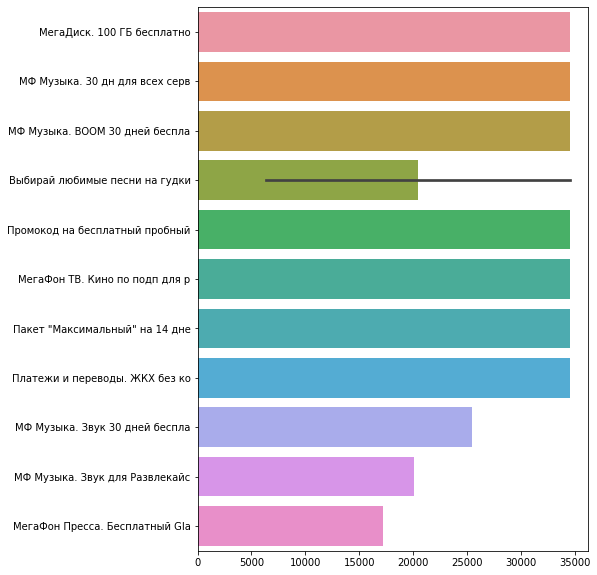

In [171]:
offer_distribution(of_density_10)